<a href="https://colab.research.google.com/github/Obiechina14/Plant_Classification/blob/main/pretrained_model_evaluation_plant_disease_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="import"></a>
## <center>Import required modules</center>

In [1]:
!pip install -q kaggle

In [2]:
#Authentication fof my Kaggle account
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.67G/2.70G [00:09<00:00, 349MB/s]
100% 2.70G/2.70G [00:09<00:00, 305MB/s]


In [4]:
import zipfile
import os

# Assuming the downloaded file is named "new-plant-diseases-dataset.zip"
zip_file_path = "new-plant-diseases-dataset.zip"
extract_directory = os.getcwd()  # Extracts to the current working directory

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_directory)

print(f"Data extracted to: {extract_directory}")

Data extracted to: /content


In [7]:
import pandas as pd
import numpy as np
from numpy import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

<a id="makedf"></a>
## <center>Make a  df dataframe and a val dataframe of the form [filepaths, labels]</center>

In [8]:
limiter=500
data_path='/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
classes=os.listdir(data_path)
filepaths=[]
labels=[]
for klass in classes:
    classpath=os.path.join(data_path, klass)
    flist=os.listdir(classpath)
    if len(flist) > limiter:
        flist=np.random.choice(flist, limiter, replace=False)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
num_of_classes=len(classes)


<a id="makettv"></a>
## <center>Make train, test and valid dataframes from df</center>

In [9]:
'''partition df into a train set with 80% of the images, a test set with 10% of the images and a vaslidation set with 10% of the images'''
train_df, dummy_df=train_test_split(df, train_size=.8, random_state=123, shuffle=True, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, random_state=123, shuffle=True, stratify=dummy_df['labels'])
print(f'test_df length= {len(test_df)}  train_df lngth= {len(train_df)}  valid_df length= {len(valid_df)}')
train_balance=train_df['labels'].value_counts()
print(f'the train_set contain {num_of_classes} class, the class balance is:\n {train_balance}')

test_df length= 1900  train_df lngth= 15200  valid_df length= 1900
the train_set contain 38 class, the class balance is:
 labels
Tomato___Tomato_mosaic_virus                          400
Strawberry___healthy                                  400
Apple___Black_rot                                     400
Corn_(maize)___Northern_Leaf_Blight                   400
Grape___healthy                                       400
Grape___Black_rot                                     400
Peach___Bacterial_spot                                400
Orange___Haunglongbing_(Citrus_greening)              400
Tomato___Septoria_leaf_spot                           400
Pepper,_bell___Bacterial_spot                         400
Potato___Early_blight                                 400
Tomato___Early_blight                                 400
Strawberry___Leaf_scorch                              400
Apple___Cedar_apple_rust                              400
Tomato___Bacterial_spot                               400
C

<a id="balance"></a>
## <center>Define a function to balance the dataframe to have a fixed number of images per class</center>

In [10]:
''' dataset is not balanced .
Use agmentation to balance the dataset Define a function to balance the dataset'''
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image): # given an image this function returns an augmented image
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        msg=f'augmenting images in train set  for class {label}                                              '
        print(msg, '\r', end='')
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            desc=f'augmenting class {label:25s}'
            for i in range(delta):
                j= i % sample_count # need this because we may have to go through the image list several times to get the needed number
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count

    print('')
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

In [11]:
img_size= (224,224)
n=200
column='labels'
working_dir=r'/content'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  15200
augmenting images in train set  for class Tomato___healthy                                               
Total Augmented images created=  0
Length of augmented dataframe is now  15200


<a id="makegen"></a>
## <center>Make train, test and valid generators</center>

In [12]:
batch_size=50
ycol='labels'
gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,seed=123,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,seed=123,
                                                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels

Found 15200 validated image filenames belonging to 38 classes.
Found 1900 validated image filenames belonging to 38 classes.
Found 1900 validated image filenames belonging to 38 classes.


<a id="makef1"></a>
## <center>Define a function to generate F1 score metric</center>

In [13]:
'''define a function to compute the F1_score metric'''
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a id="model"></a>
## <center>Define a function to create a model</center>

In [14]:
def make_model(img_size, num_of_classes, lr, modnum):
    """
    Creates a specific model based on the provided parameters.

    Parameters:
    img_size (tuple): Size of the input images (height, width).
    num_of_classes (int): Number of output classes.
    lr (float): Learning rate for the optimizer.
    modnum (int): Model number to select the base model.

    Returns:
    model (tf.keras.Model): Compiled Keras model.
    """
    img_shape = (img_size[0], img_size[1], 3)

    if modnum == 1:
        base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created MobileNetV2'
    elif modnum == 2:
        base_model = tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created MobileNetV3 Large model'
    elif modnum == 3:
        base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNetV2 B0 model'
    elif modnum == 4:
        base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created VGG16 model'
    elif modnum == 5:
        base_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created Inception_ResNet model'
    elif modnum == 6:
        base_model = tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created DenseNet model'
    else:
        raise ValueError("Invalid modnum value. Please choose a value between 1 and 5.")


    base_model.trainable = True
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=0.4, seed=123)(x)
    output = Dense(num_of_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    msg += f' with initial learning rate set to {lr}'
    print(msg)

    return model

def tr_plot(tr_data):
    start_epoch = 0
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc) + start_epoch

    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]

    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')

    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)

    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)

    axes[1].legend()

    plt.tight_layout()
    plt.show()

def predictor(model, test_gen):
    classes = list(test_gen.class_indices.keys())

    preds = model.predict(test_gen, verbose=1)

    errors = 0
    pred_indices = []

    test_count = len(preds)

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        pred_indices.append(pred_index)

        true_index = test_gen.labels[i]

        if pred_index != true_index:
            errors += 1

    accuracy = (test_count - errors) * 100 / test_count

    ytrue = np.array(test_gen.labels, dtype='int')
    ypred = np.array(pred_indices, dtype='int')

    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    msg = f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'

    print(msg)

    cm = confusion_matrix(ytrue, ypred)

    # plot the confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(len(classes)) + .5, classes, rotation=90)
    plt.yticks(np.arange(len(classes)) + .5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    clr = classification_report(ytrue, ypred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", clr)

Created MobileNetV2 with initial learning rate set to 0.0001
Epoch 1/20
304/304 [==============================] - 87s 139ms/step - loss: 10.2527 - accuracy: 0.2414 - val_loss: 10.4546 - val_accuracy: 0.2895 - lr: 1.0000e-04
Epoch 2/20
304/304 [==============================] - 34s 112ms/step - loss: 8.3298 - accuracy: 0.5694 - val_loss: 10.4534 - val_accuracy: 0.5642 - lr: 1.0000e-04
Epoch 3/20
304/304 [==============================] - 32s 106ms/step - loss: 7.2891 - accuracy: 0.7066 - val_loss: 9.9146 - val_accuracy: 0.7358 - lr: 1.0000e-04
Epoch 4/20
304/304 [==============================] - 32s 105ms/step - loss: 6.4178 - accuracy: 0.7814 - val_loss: 8.5687 - val_accuracy: 0.8332 - lr: 1.0000e-04
Epoch 5/20
304/304 [==============================] - 34s 112ms/step - loss: 5.6457 - accuracy: 0.8303 - val_loss: 7.4166 - val_accuracy: 0.8811 - lr: 1.0000e-04
Epoch 6/20
304/304 [==============================] - 32s 105ms/step - loss: 4.9554 - accuracy: 0.8628 - val_loss: 6.3970 - va

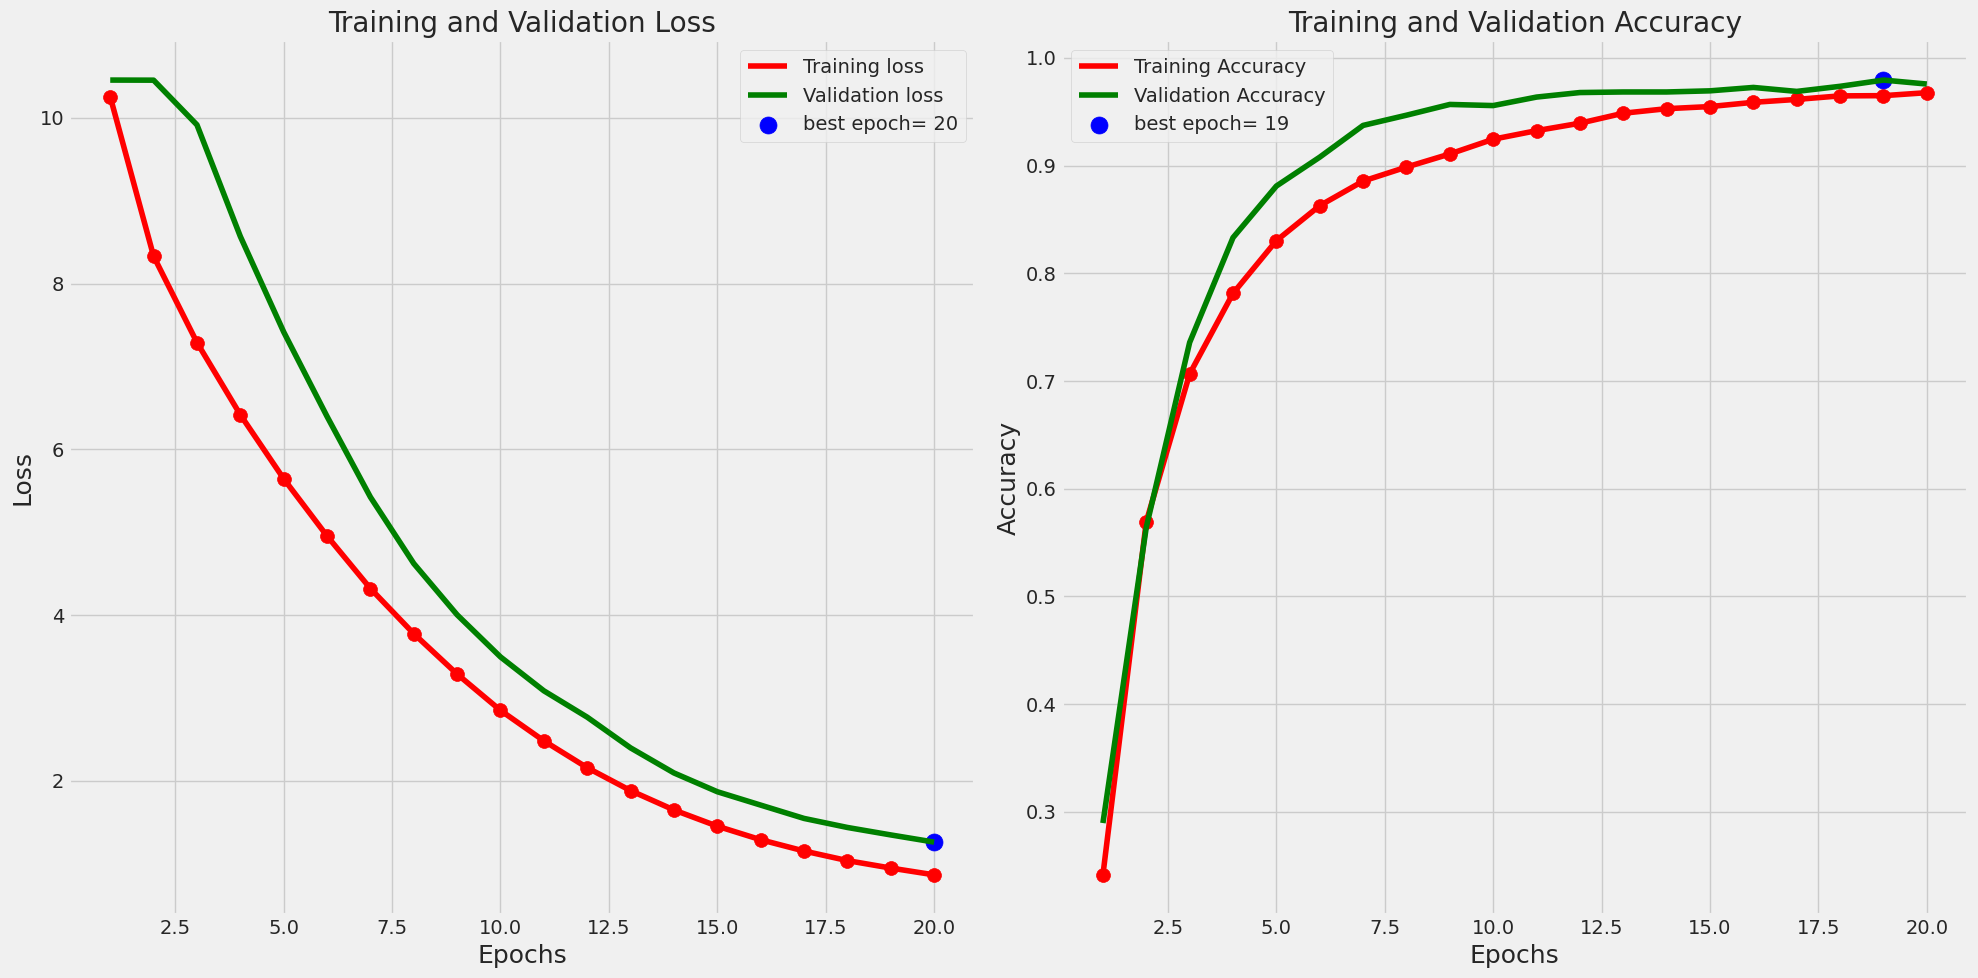

25/25 [==============================] - 11s 129ms/step
There were 44 errors in 1900 tests for an accuracy of  97.68 and an F1 score of  97.66


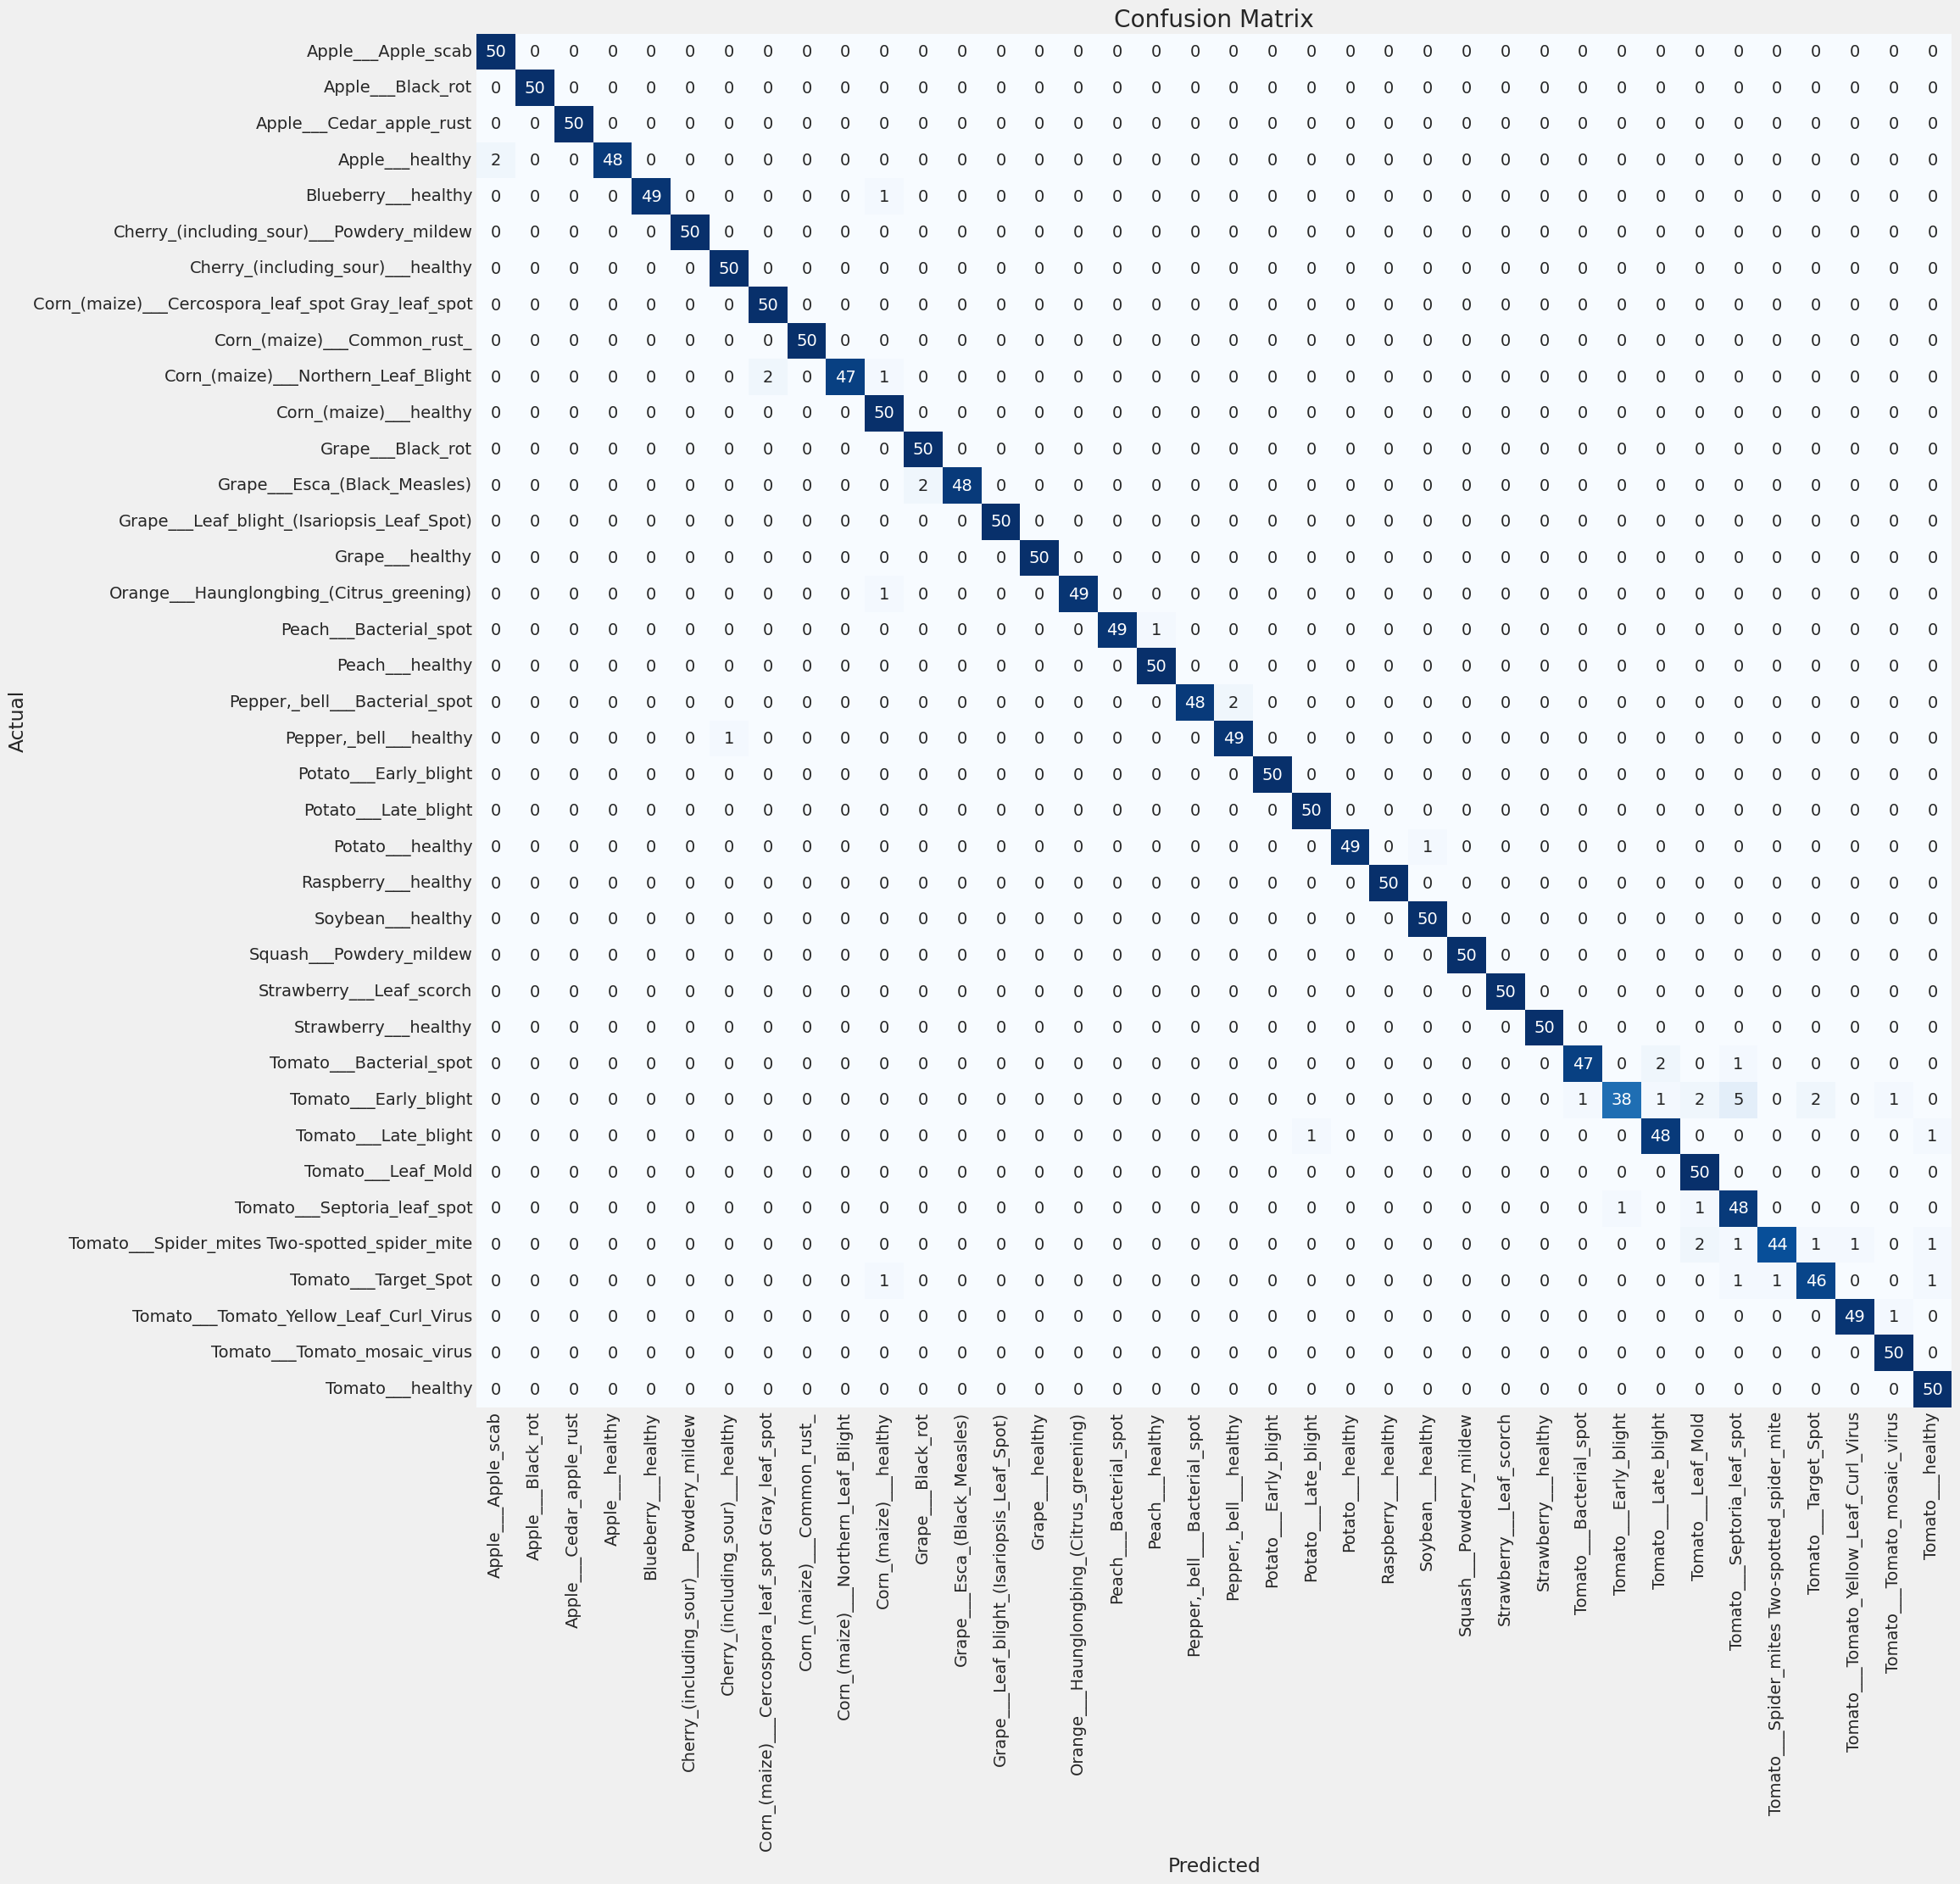

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     0.9615    1.0000    0.9804        50
                                 Apple___Black_rot     1.0000    1.0000    1.0000        50
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        50
                                   Apple___healthy     1.0000    0.9600    0.9796        50
                               Blueberry___healthy     1.0000    0.9800    0.9899        50
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        50
                 Cherry_(including_sour)___healthy     0.9804    1.0000    0.9901        50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9615    1.0000    0.9804        50
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        50
               Corn_(maize)___No

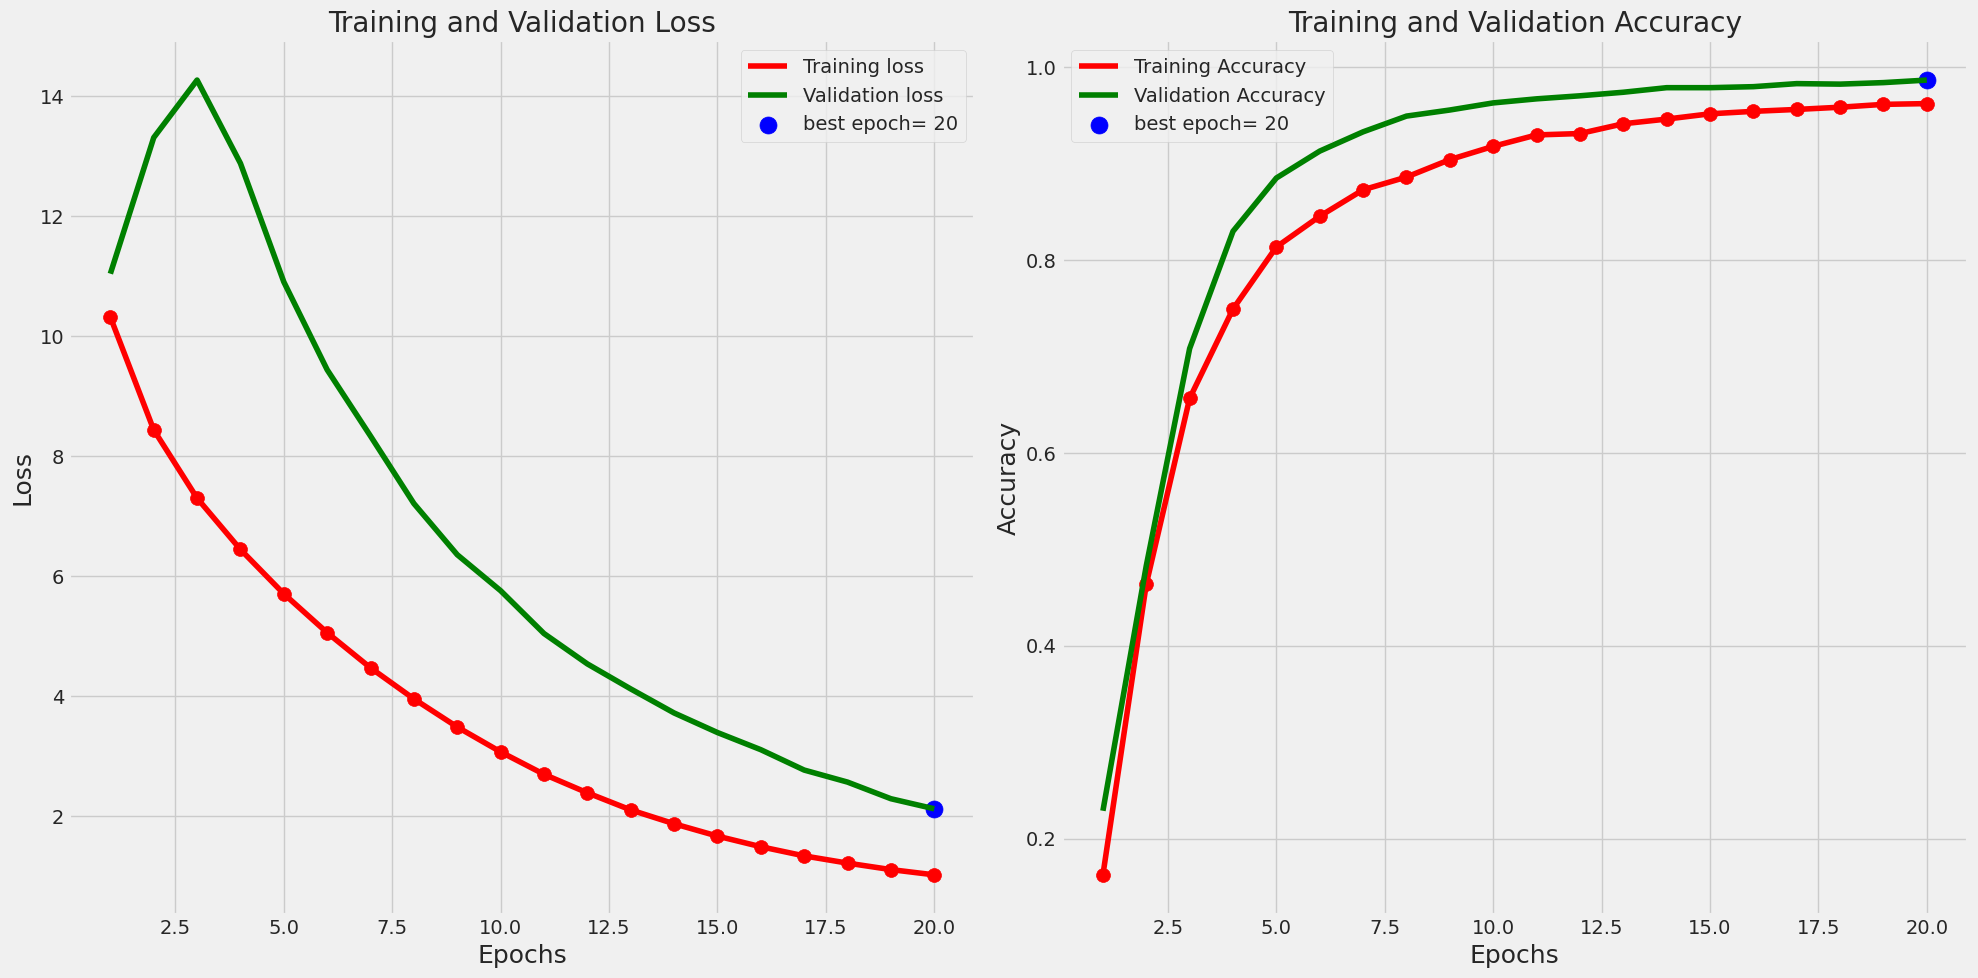

25/25 [==============================] - 11s 128ms/step
There were 28 errors in 1900 tests for an accuracy of  98.53 and an F1 score of  98.52


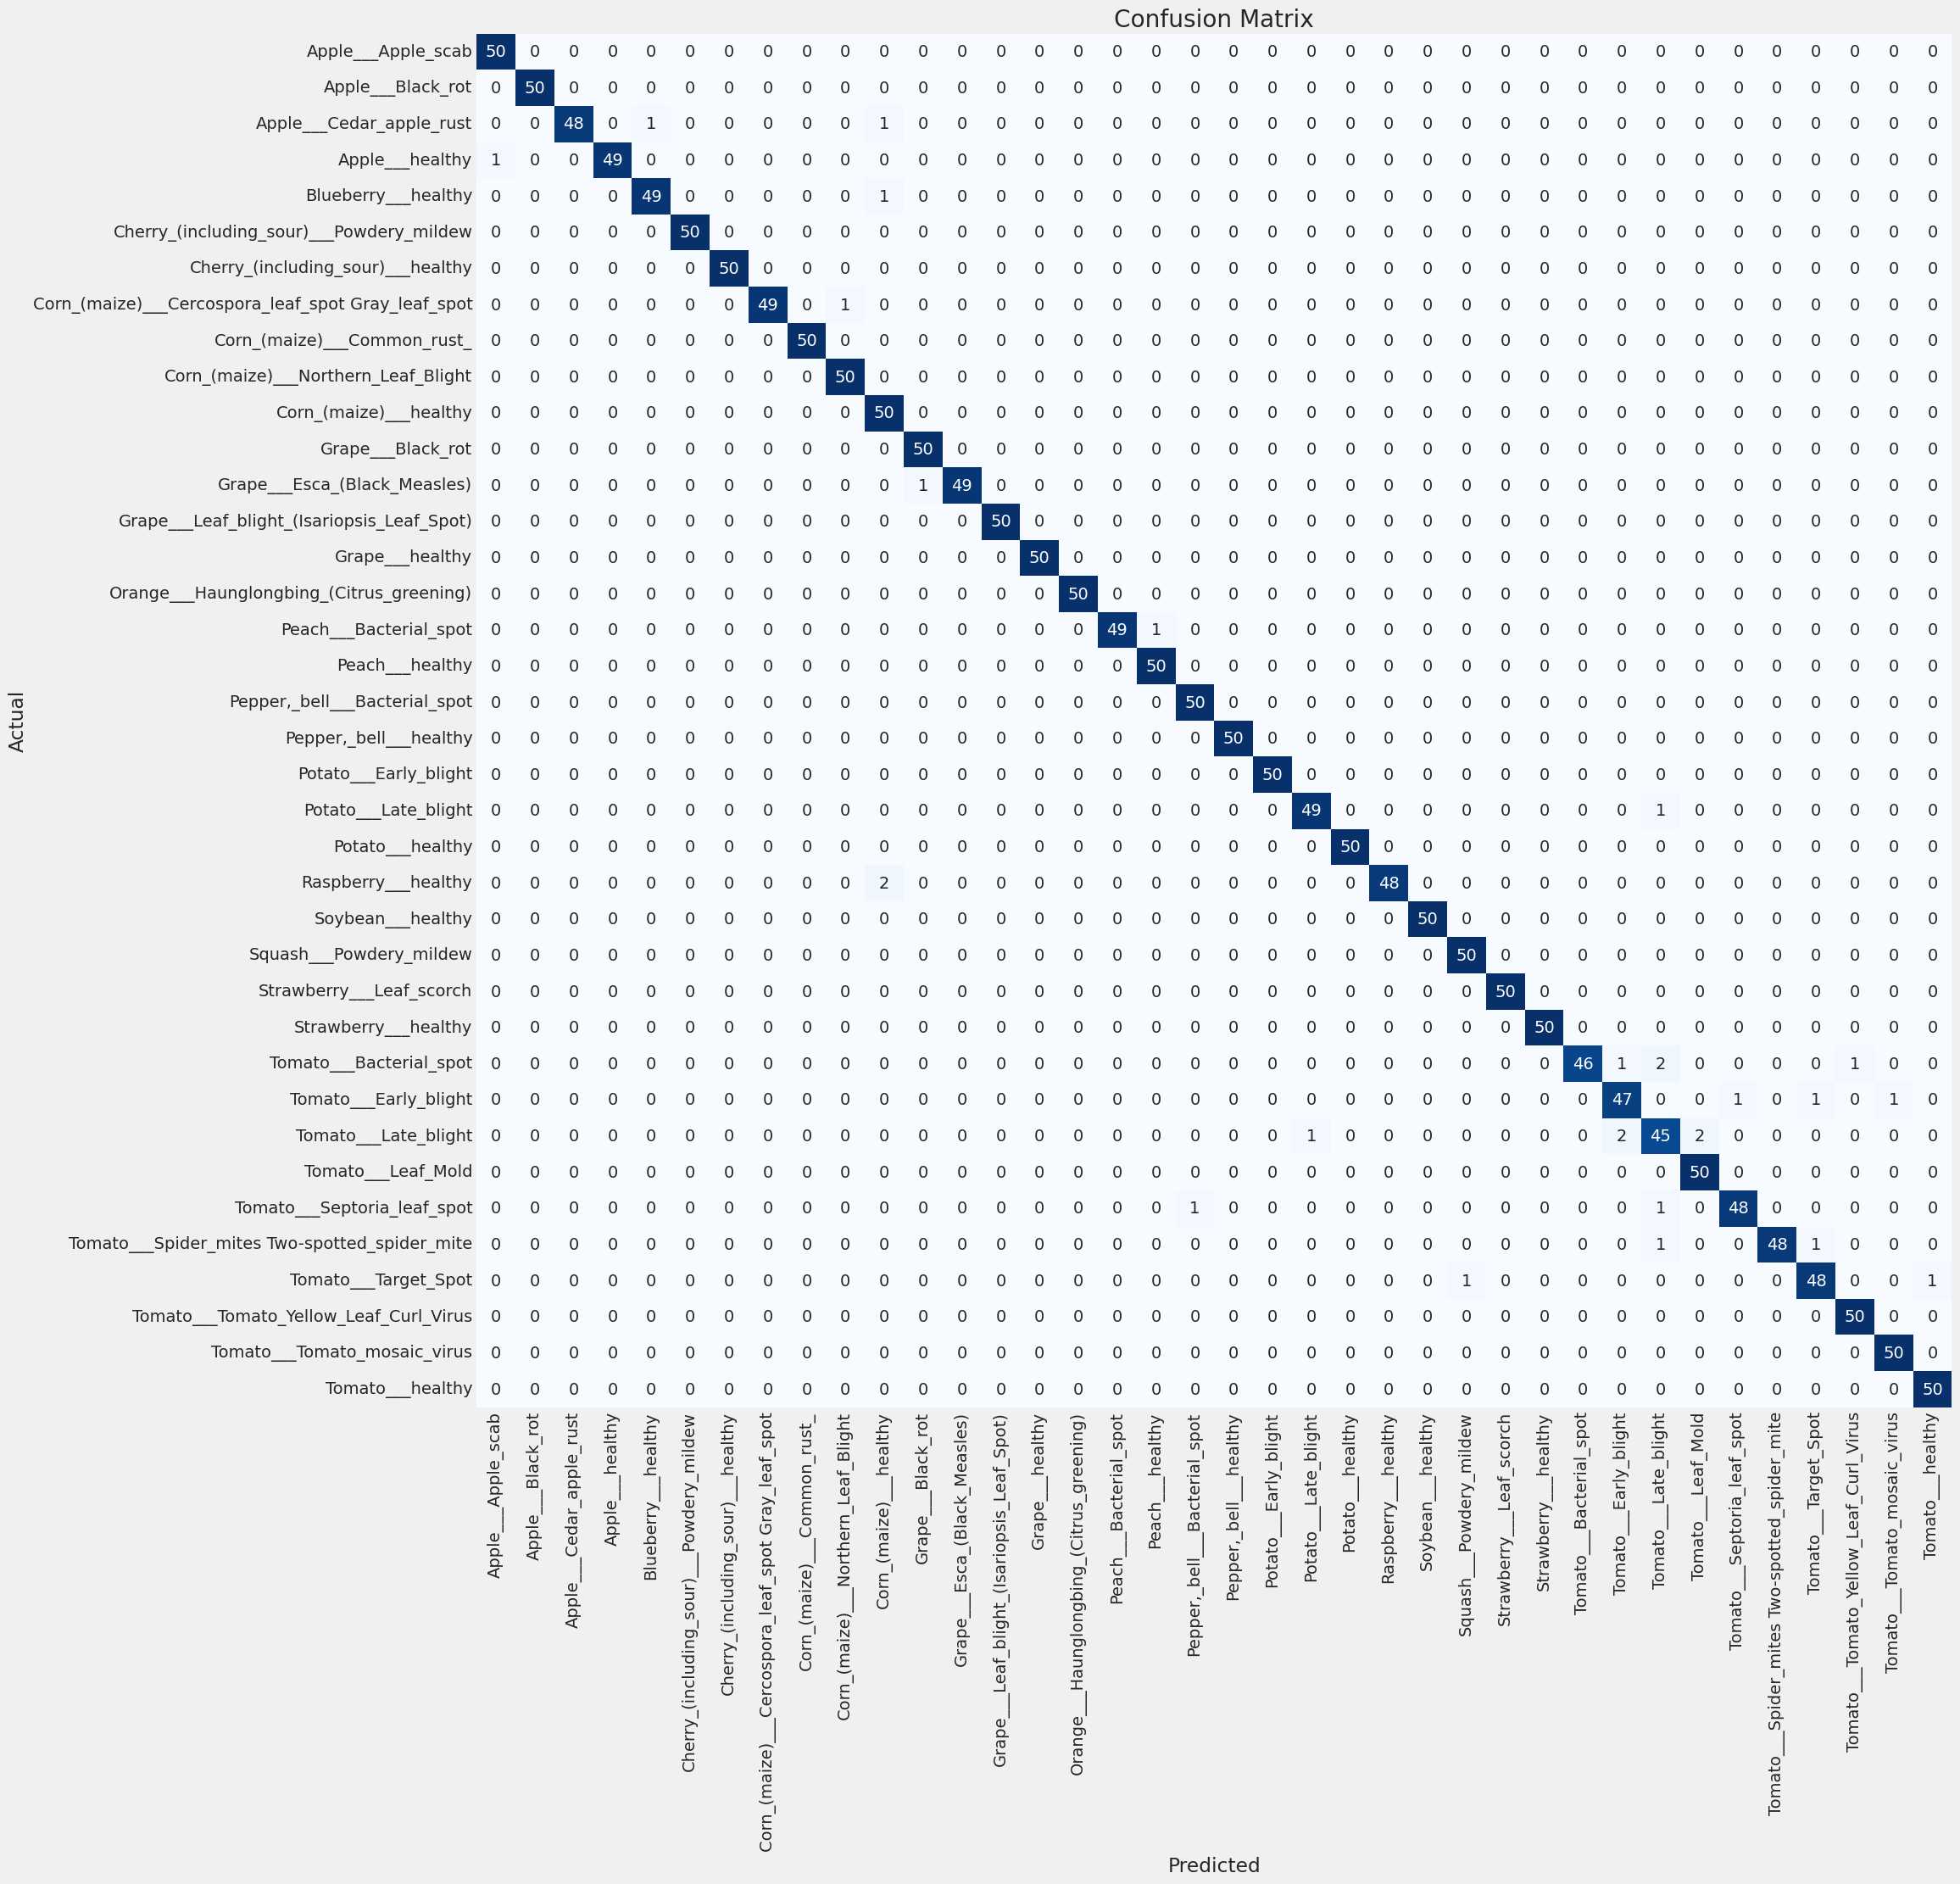

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     0.9804    1.0000    0.9901        50
                                 Apple___Black_rot     1.0000    1.0000    1.0000        50
                          Apple___Cedar_apple_rust     1.0000    0.9600    0.9796        50
                                   Apple___healthy     1.0000    0.9800    0.9899        50
                               Blueberry___healthy     0.9800    0.9800    0.9800        50
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        50
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     1.0000    0.9800    0.9899        50
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        50
               Corn_(maize)___No

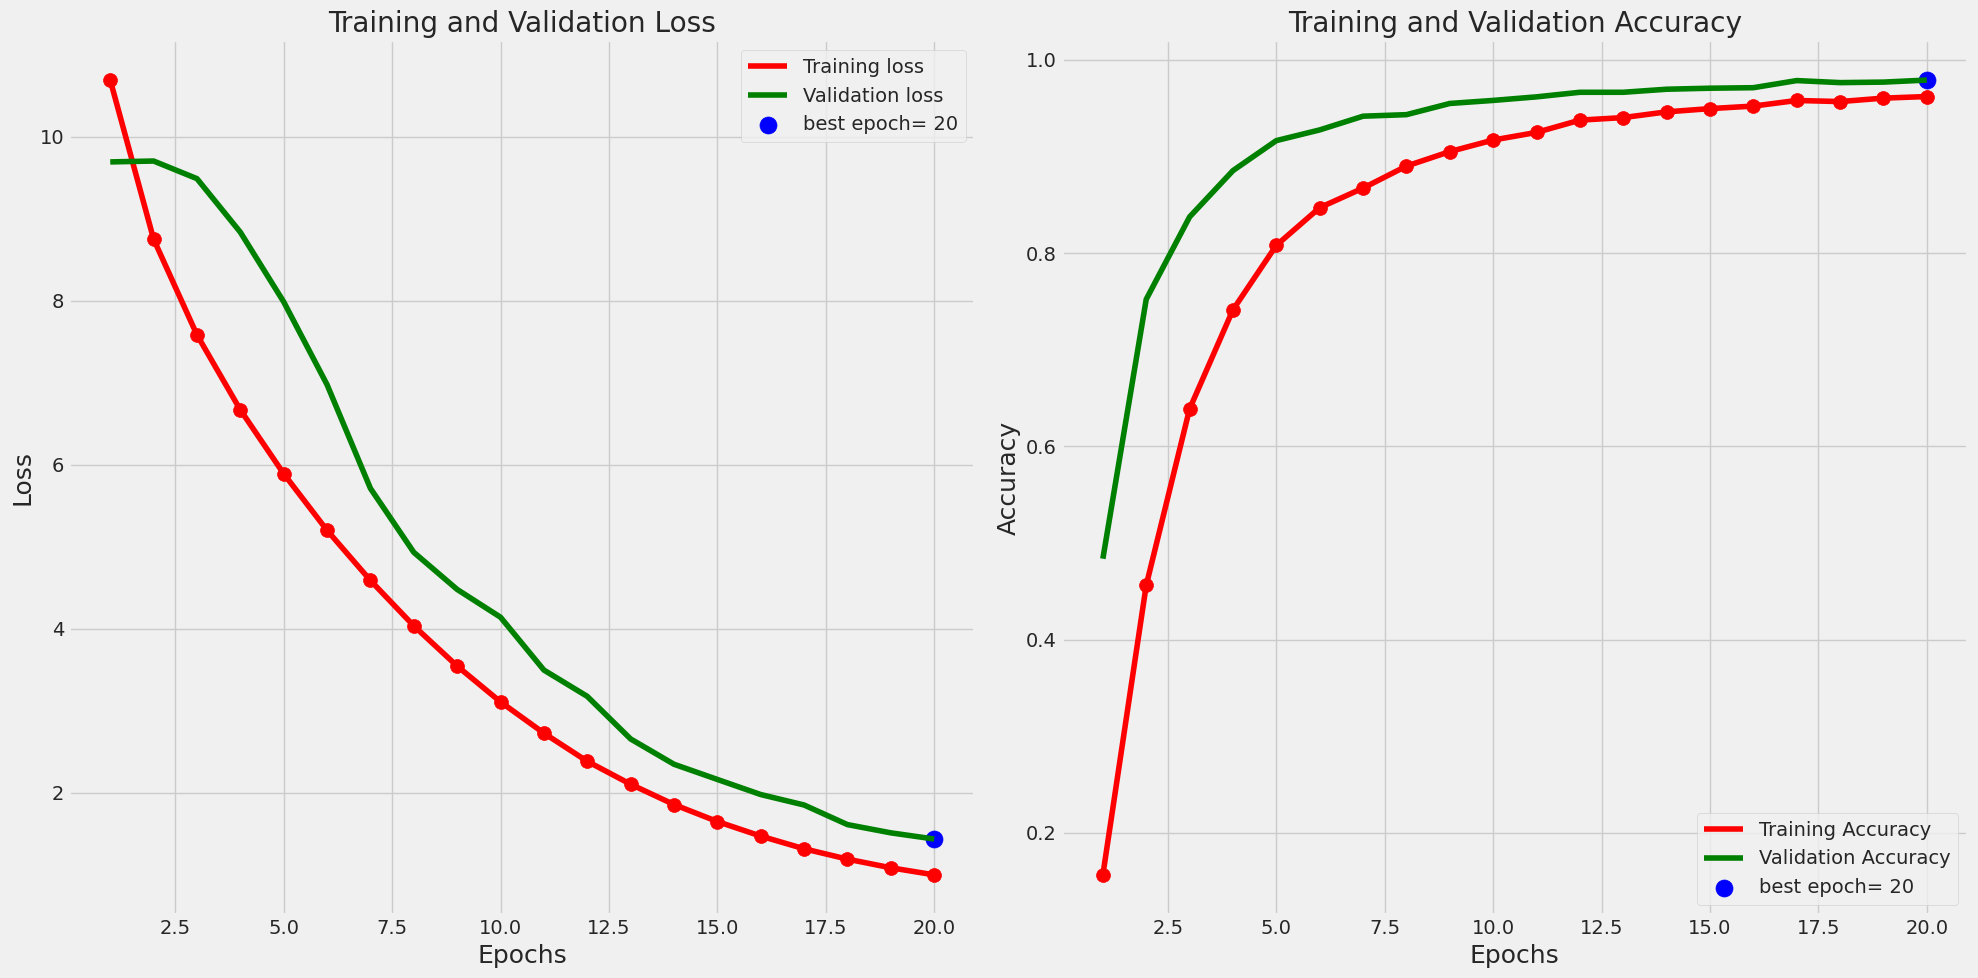

25/25 [==============================] - 14s 118ms/step
There were 46 errors in 1900 tests for an accuracy of  97.58 and an F1 score of  97.62


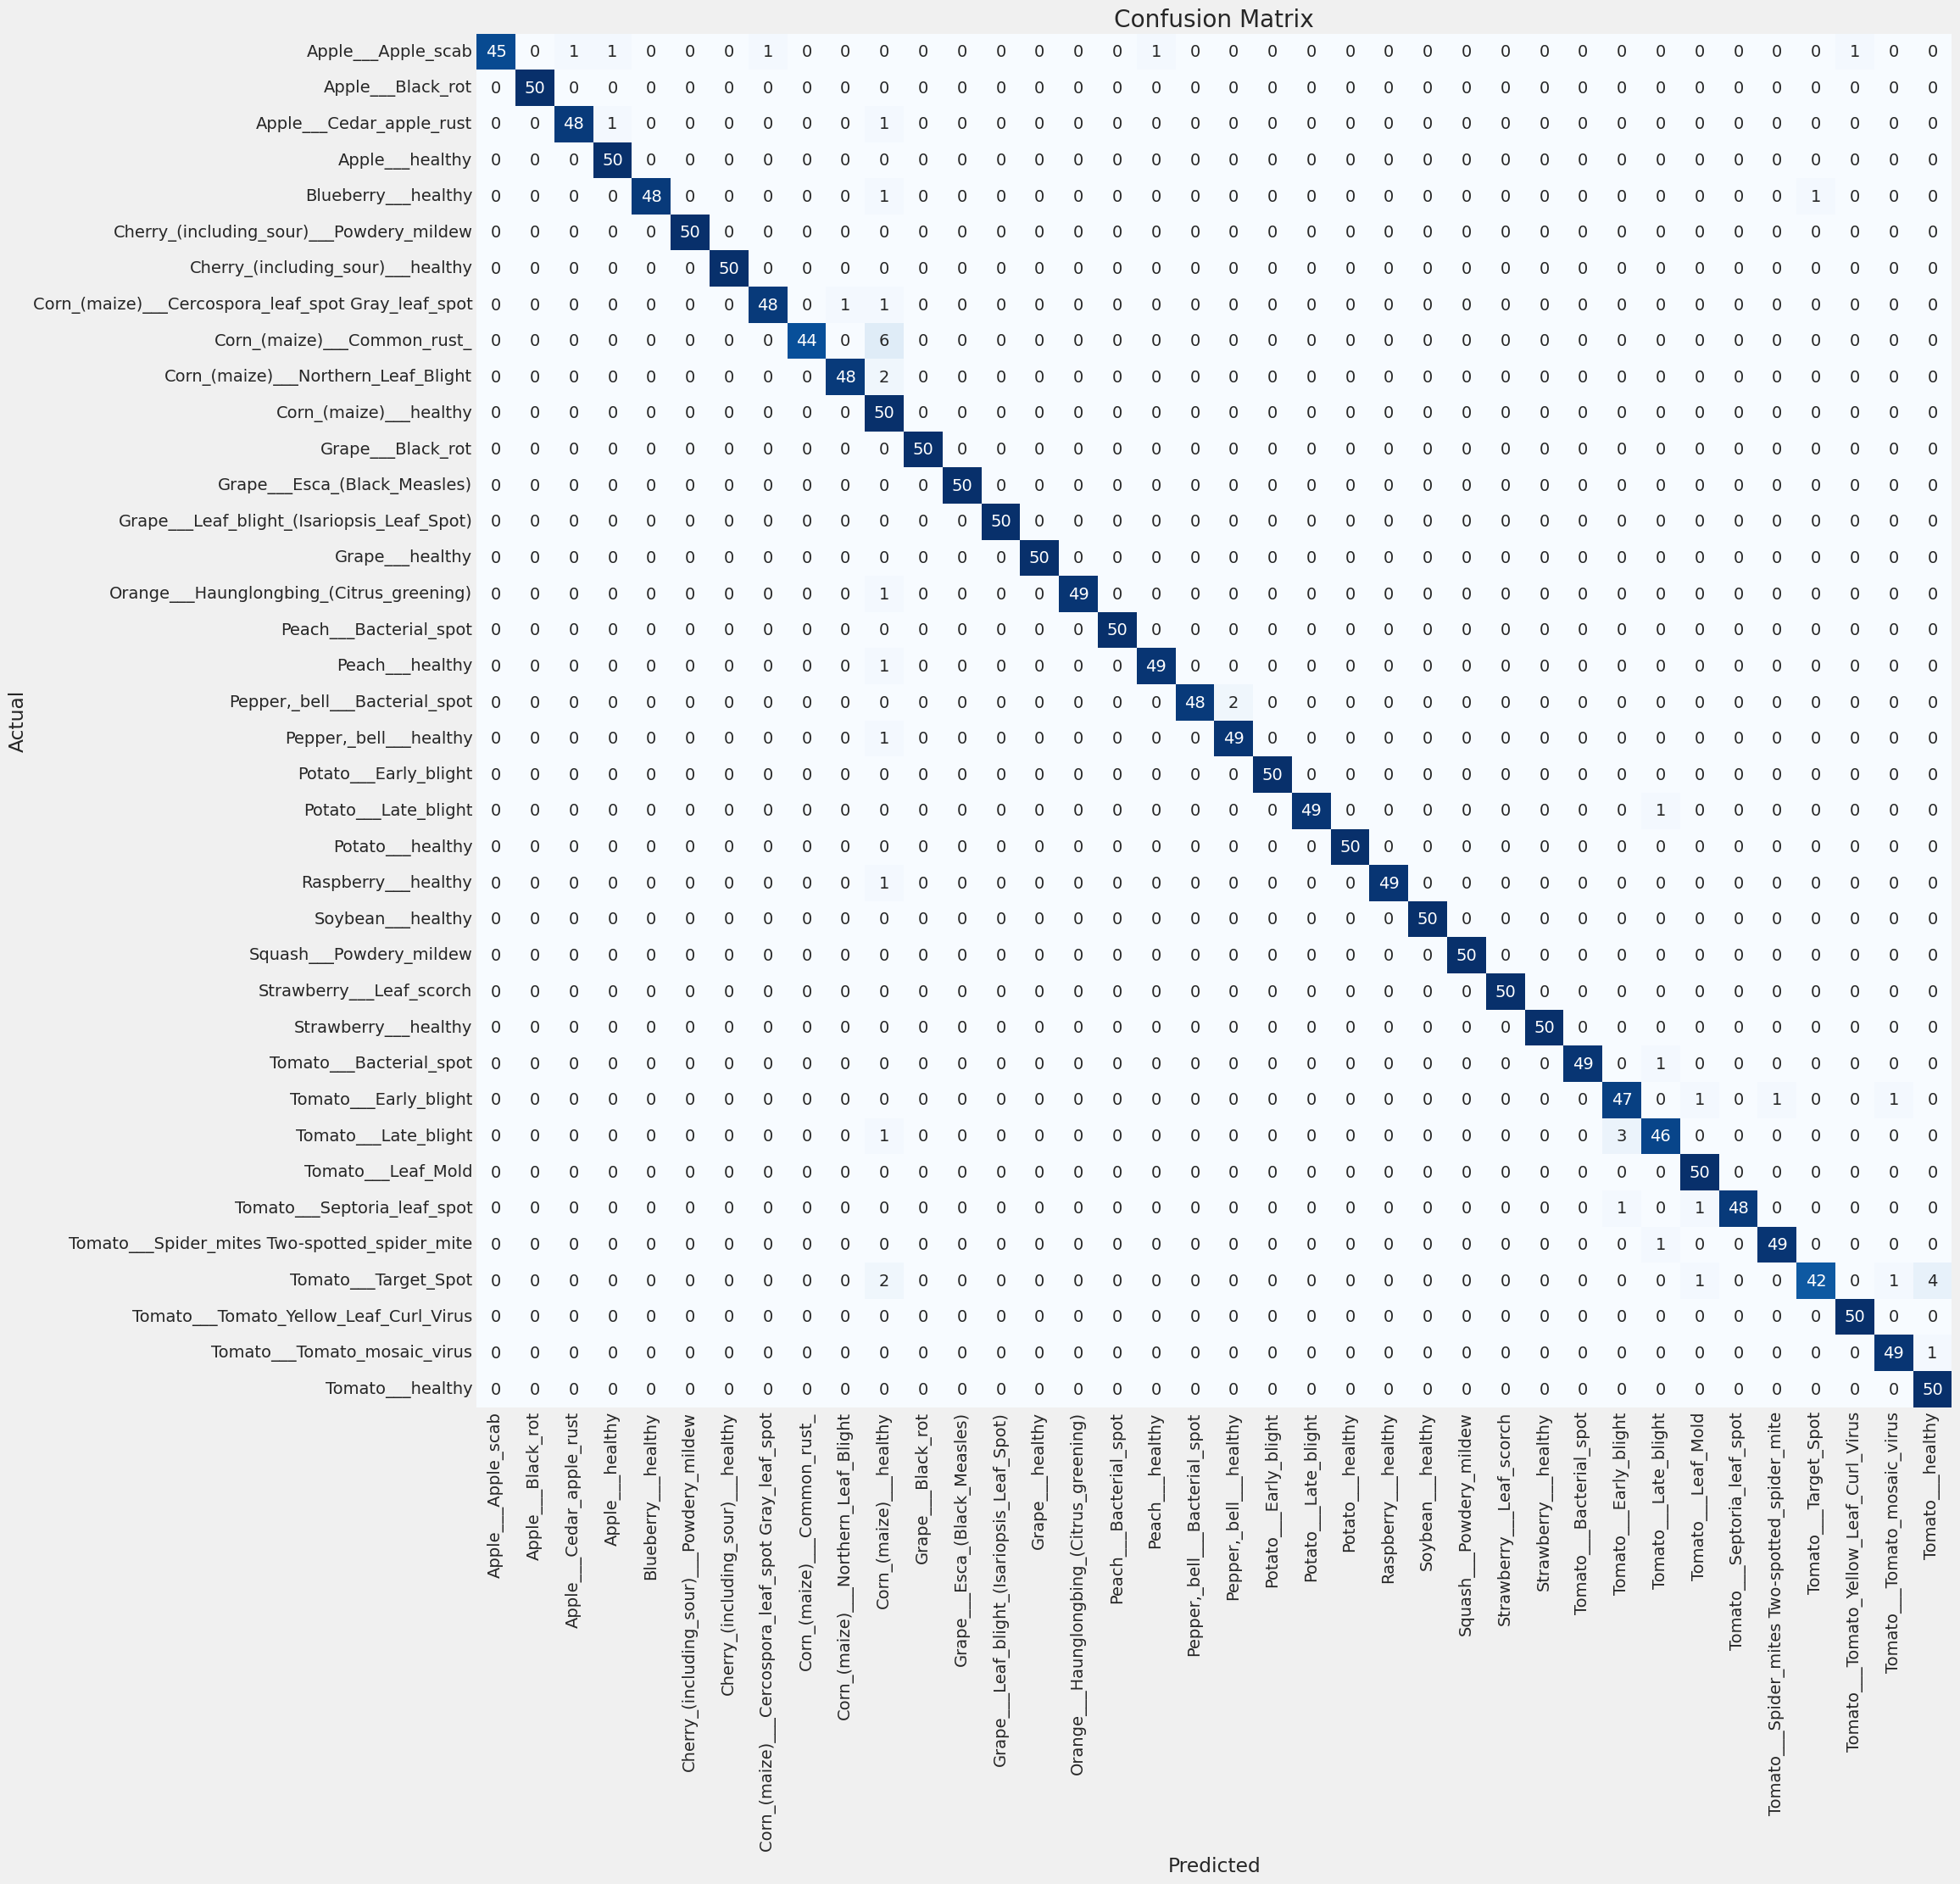

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    0.9000    0.9474        50
                                 Apple___Black_rot     1.0000    1.0000    1.0000        50
                          Apple___Cedar_apple_rust     0.9796    0.9600    0.9697        50
                                   Apple___healthy     0.9615    1.0000    0.9804        50
                               Blueberry___healthy     1.0000    0.9600    0.9796        50
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        50
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9796    0.9600    0.9697        50
                       Corn_(maize)___Common_rust_     1.0000    0.8800    0.9362        50
               Corn_(maize)___No

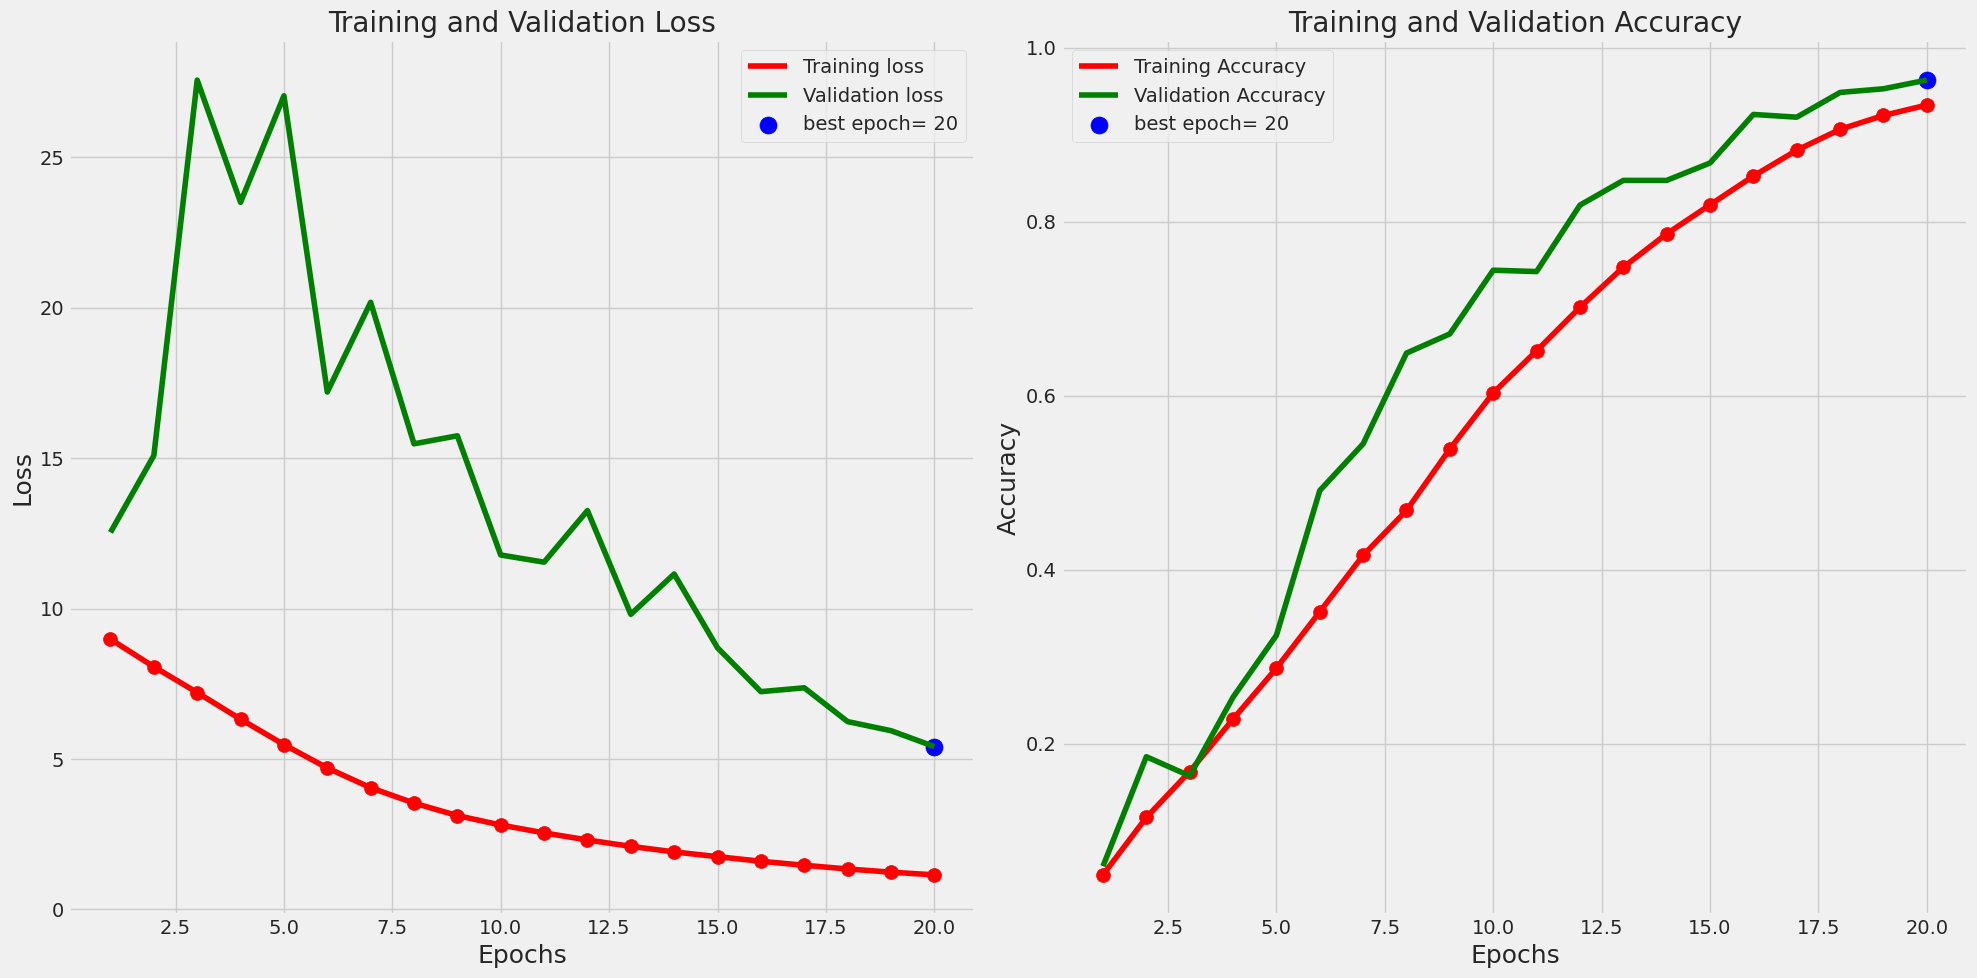

25/25 [==============================] - 12s 100ms/step
There were 59 errors in 1900 tests for an accuracy of  96.89 and an F1 score of  96.89


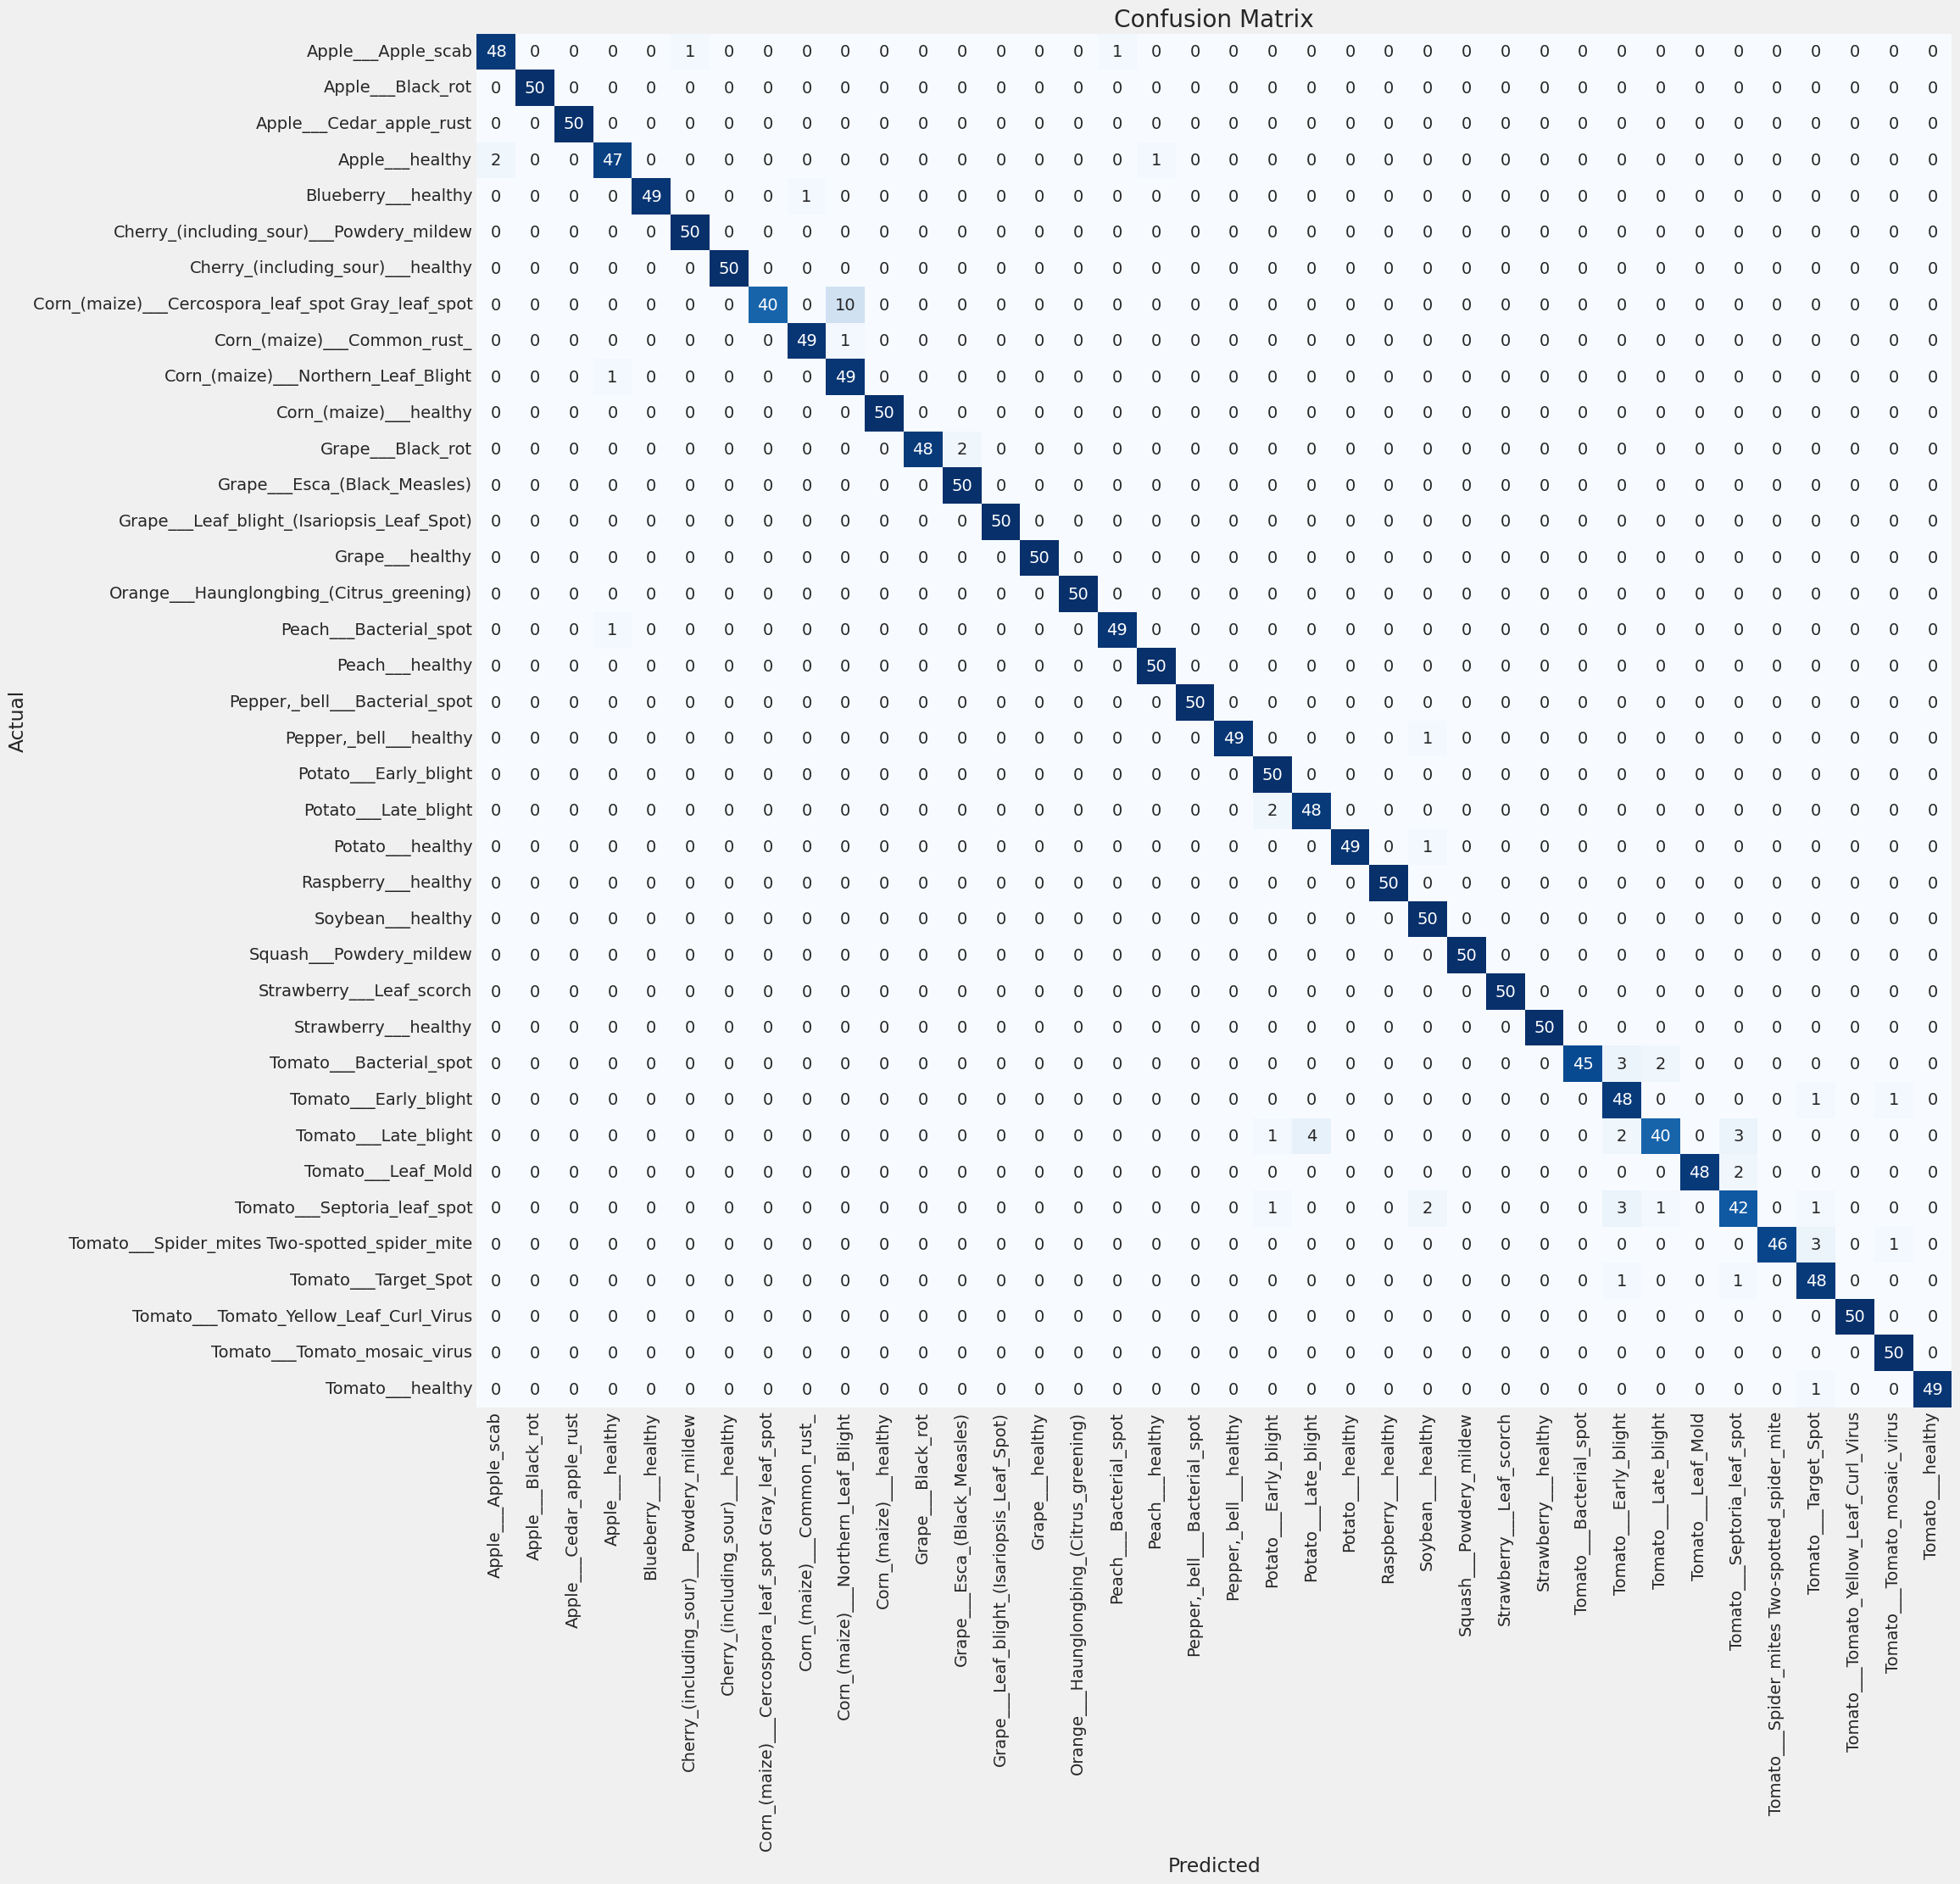

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     0.9600    0.9600    0.9600        50
                                 Apple___Black_rot     1.0000    1.0000    1.0000        50
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        50
                                   Apple___healthy     0.9592    0.9400    0.9495        50
                               Blueberry___healthy     1.0000    0.9800    0.9899        50
          Cherry_(including_sour)___Powdery_mildew     0.9804    1.0000    0.9901        50
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     1.0000    0.8000    0.8889        50
                       Corn_(maize)___Common_rust_     0.9800    0.9800    0.9800        50
               Corn_(maize)___No

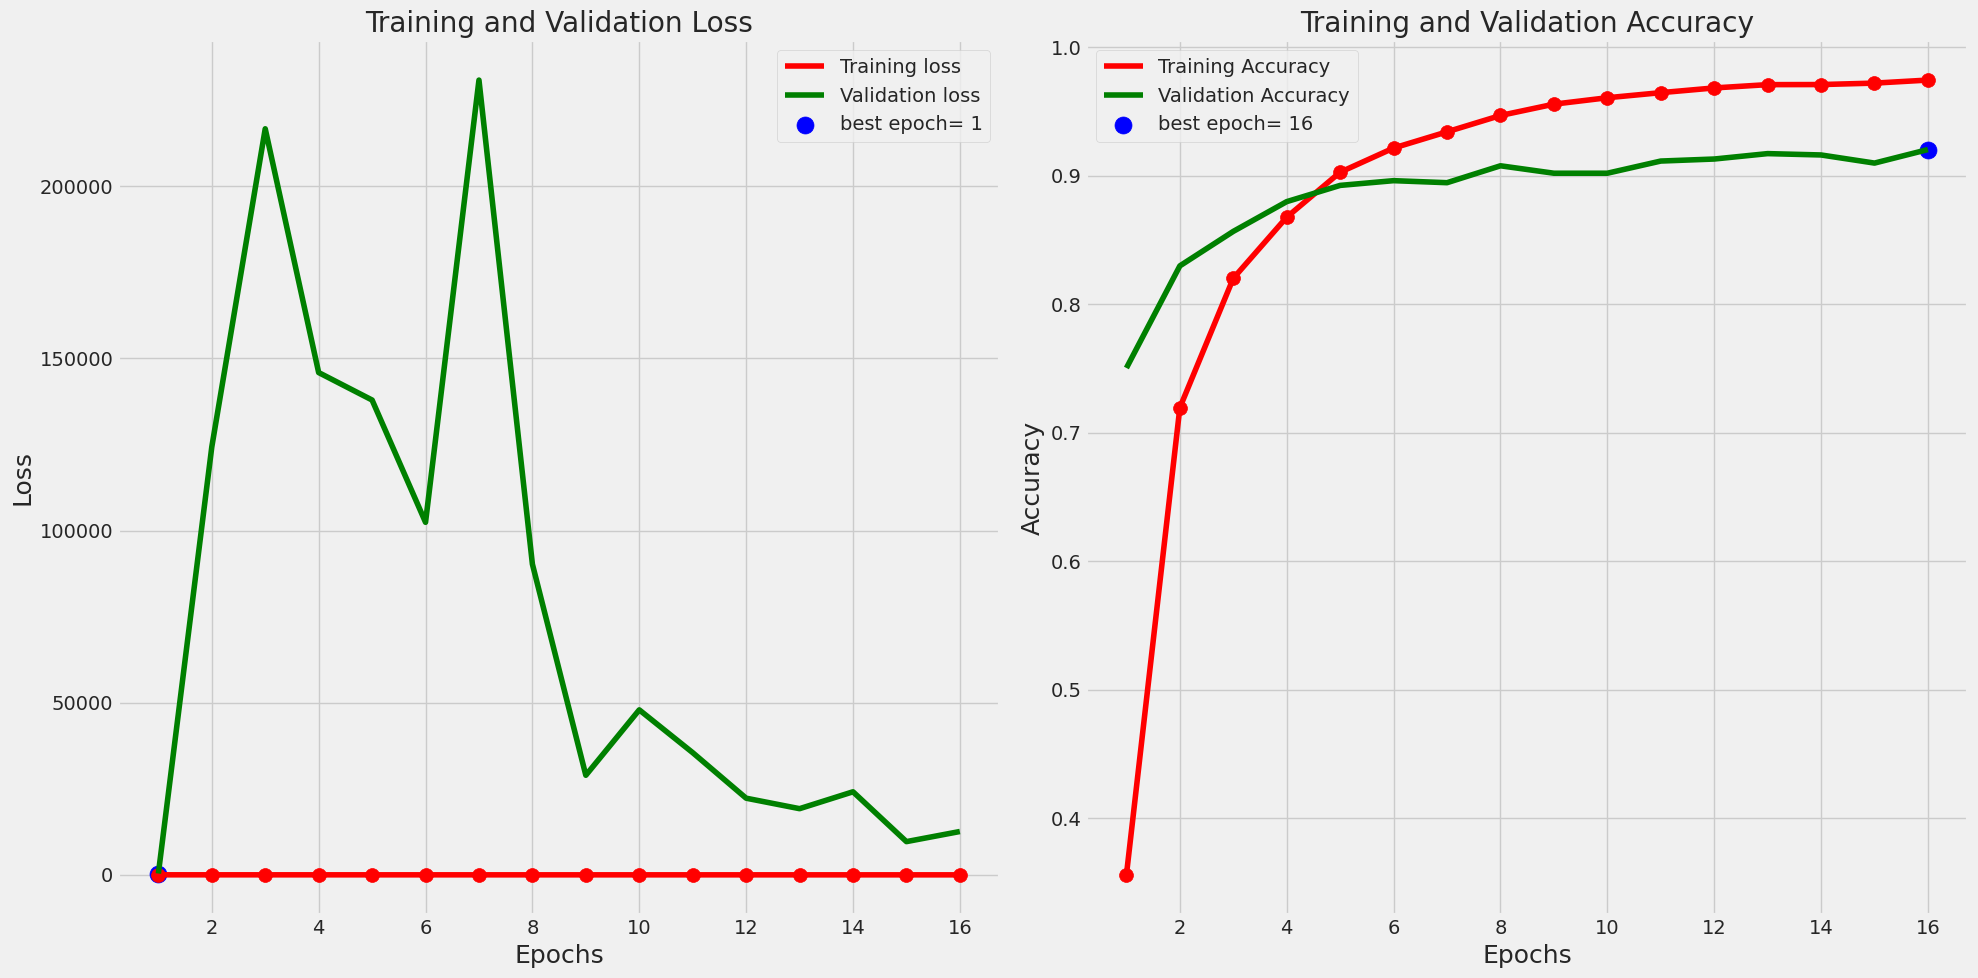

25/25 [==============================] - 31s 128ms/step
There were 526 errors in 1900 tests for an accuracy of  72.32 and an F1 score of  71.90


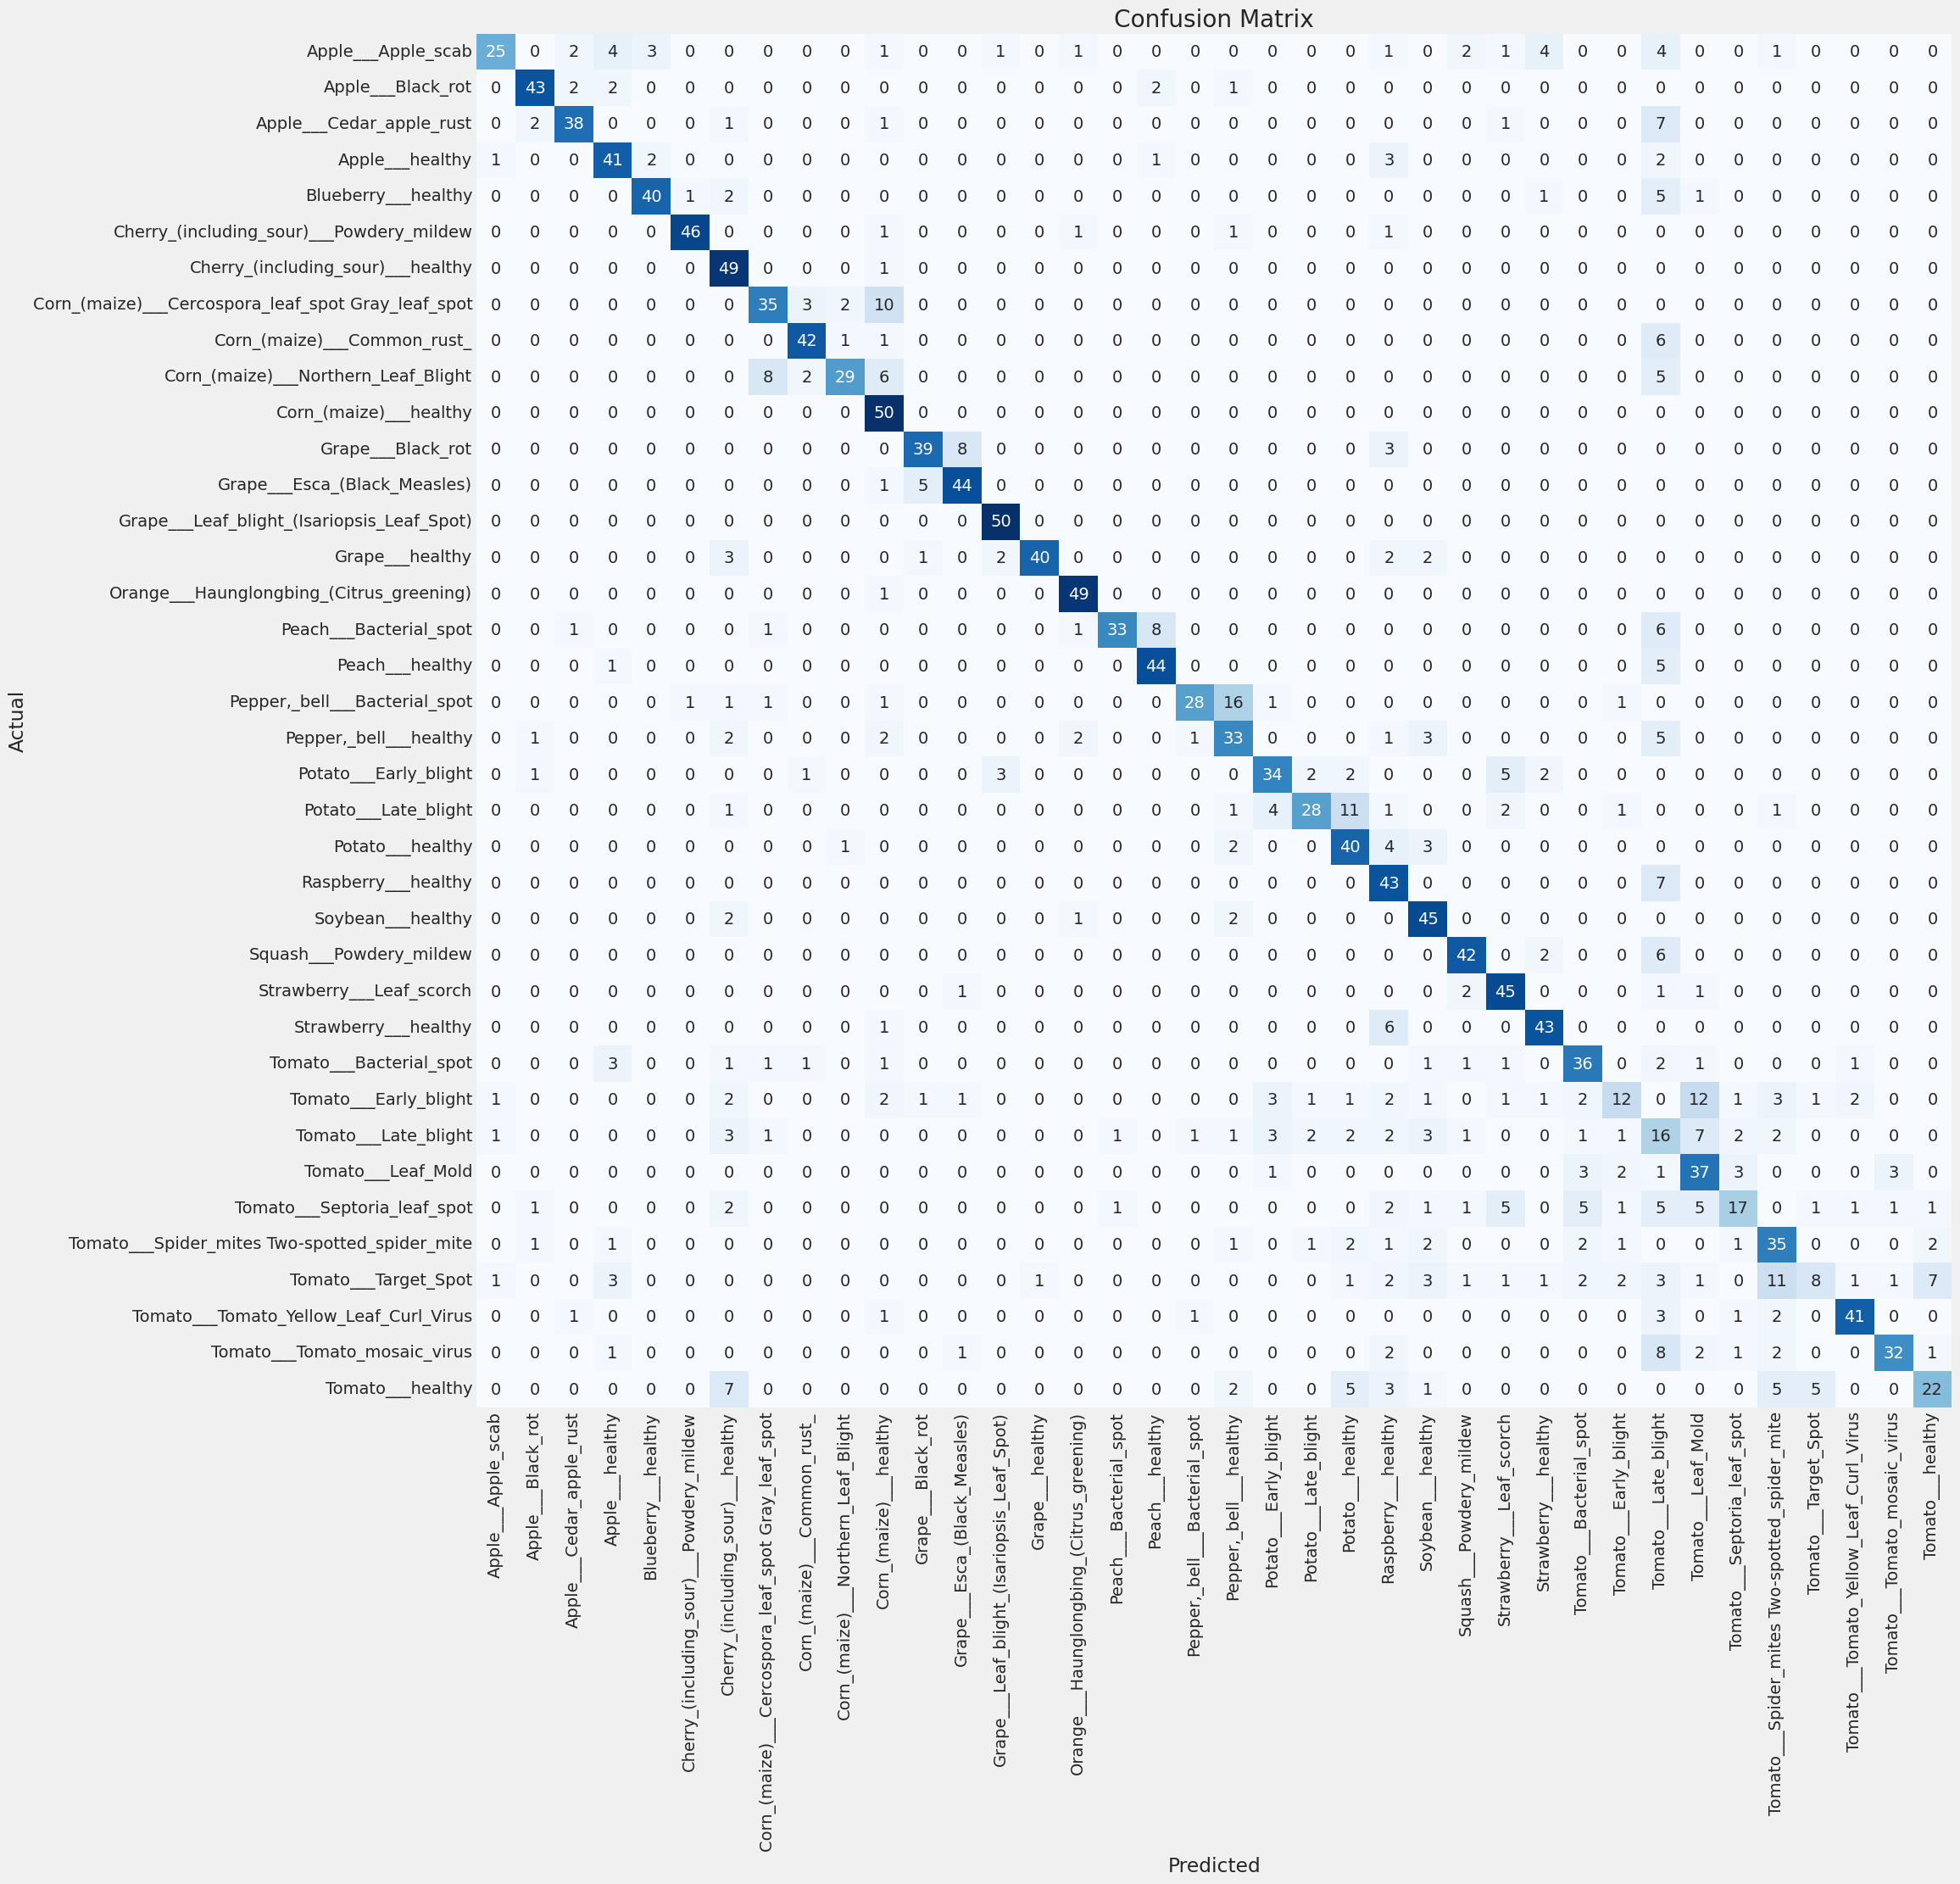

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     0.8621    0.5000    0.6329        50
                                 Apple___Black_rot     0.8776    0.8600    0.8687        50
                          Apple___Cedar_apple_rust     0.8636    0.7600    0.8085        50
                                   Apple___healthy     0.7321    0.8200    0.7736        50
                               Blueberry___healthy     0.8889    0.8000    0.8421        50
          Cherry_(including_sour)___Powdery_mildew     0.9583    0.9200    0.9388        50
                 Cherry_(including_sour)___healthy     0.6447    0.9800    0.7778        50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.7447    0.7000    0.7216        50
                       Corn_(maize)___Common_rust_     0.8571    0.8400    0.8485        50
               Corn_(maize)___No

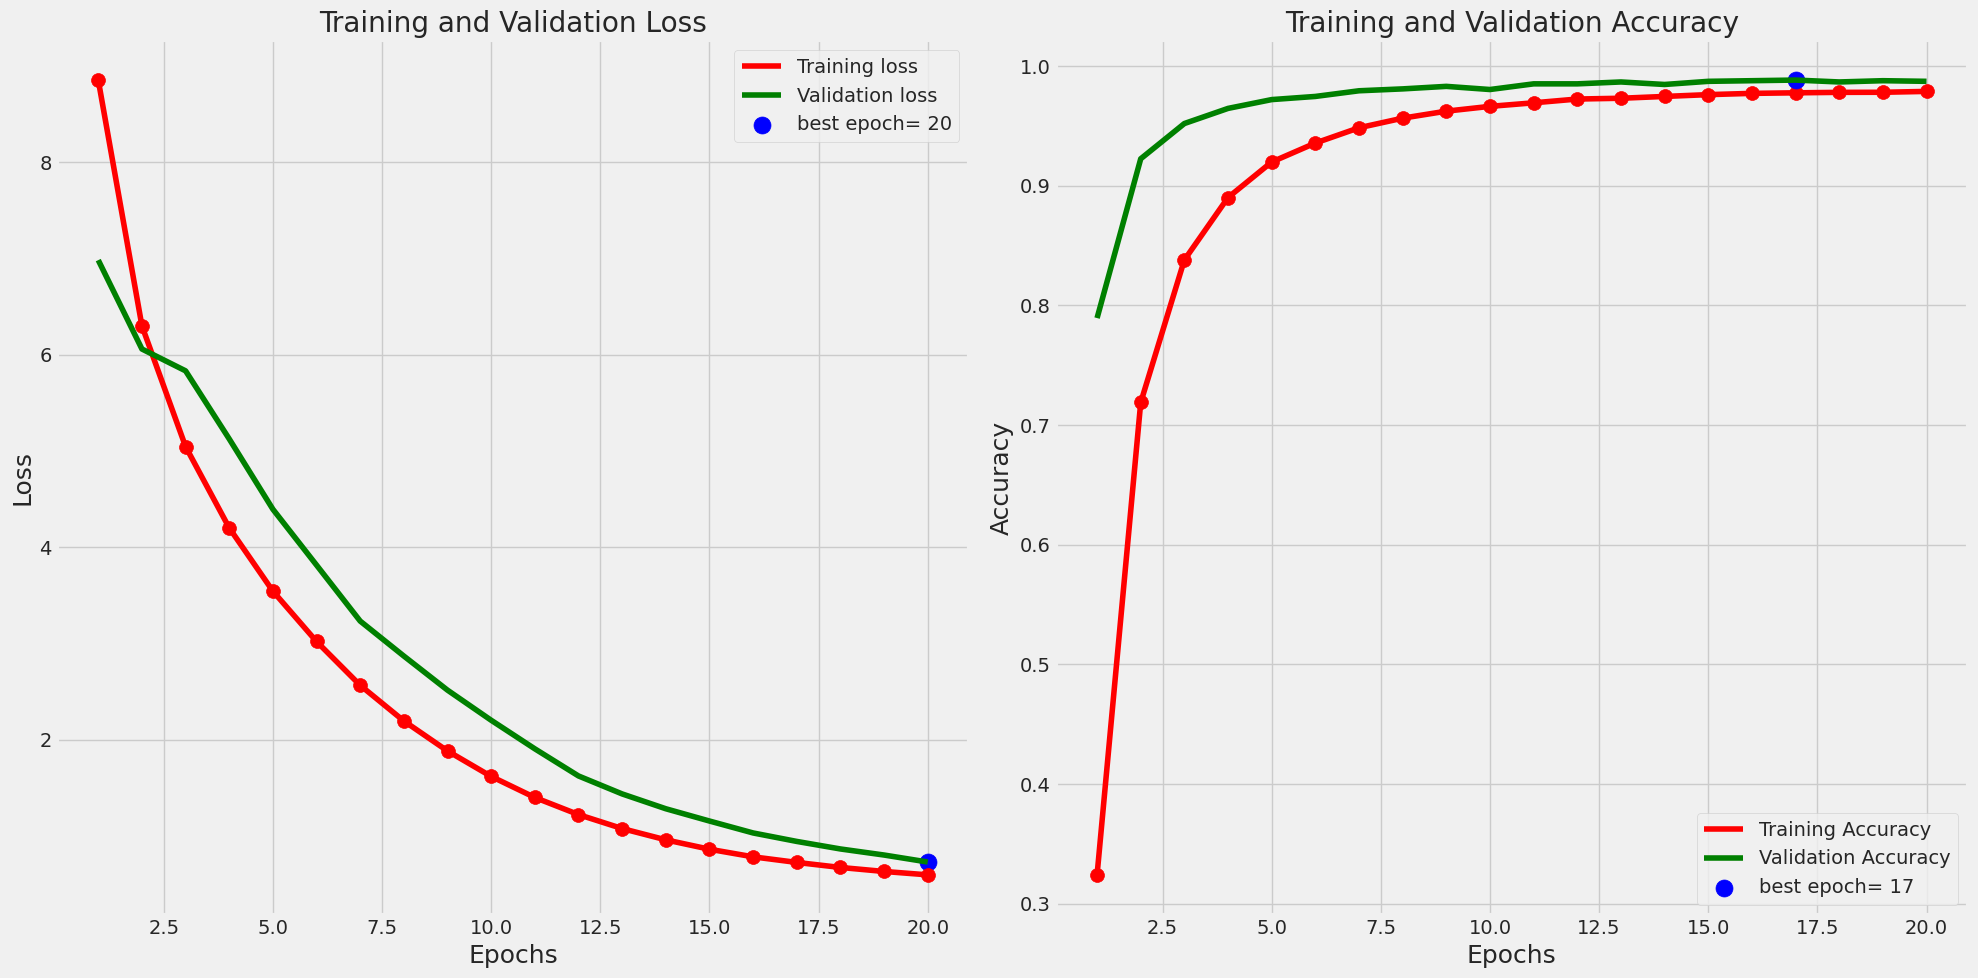

25/25 [==============================] - 20s 125ms/step
There were 32 errors in 1900 tests for an accuracy of  98.32 and an F1 score of  98.31


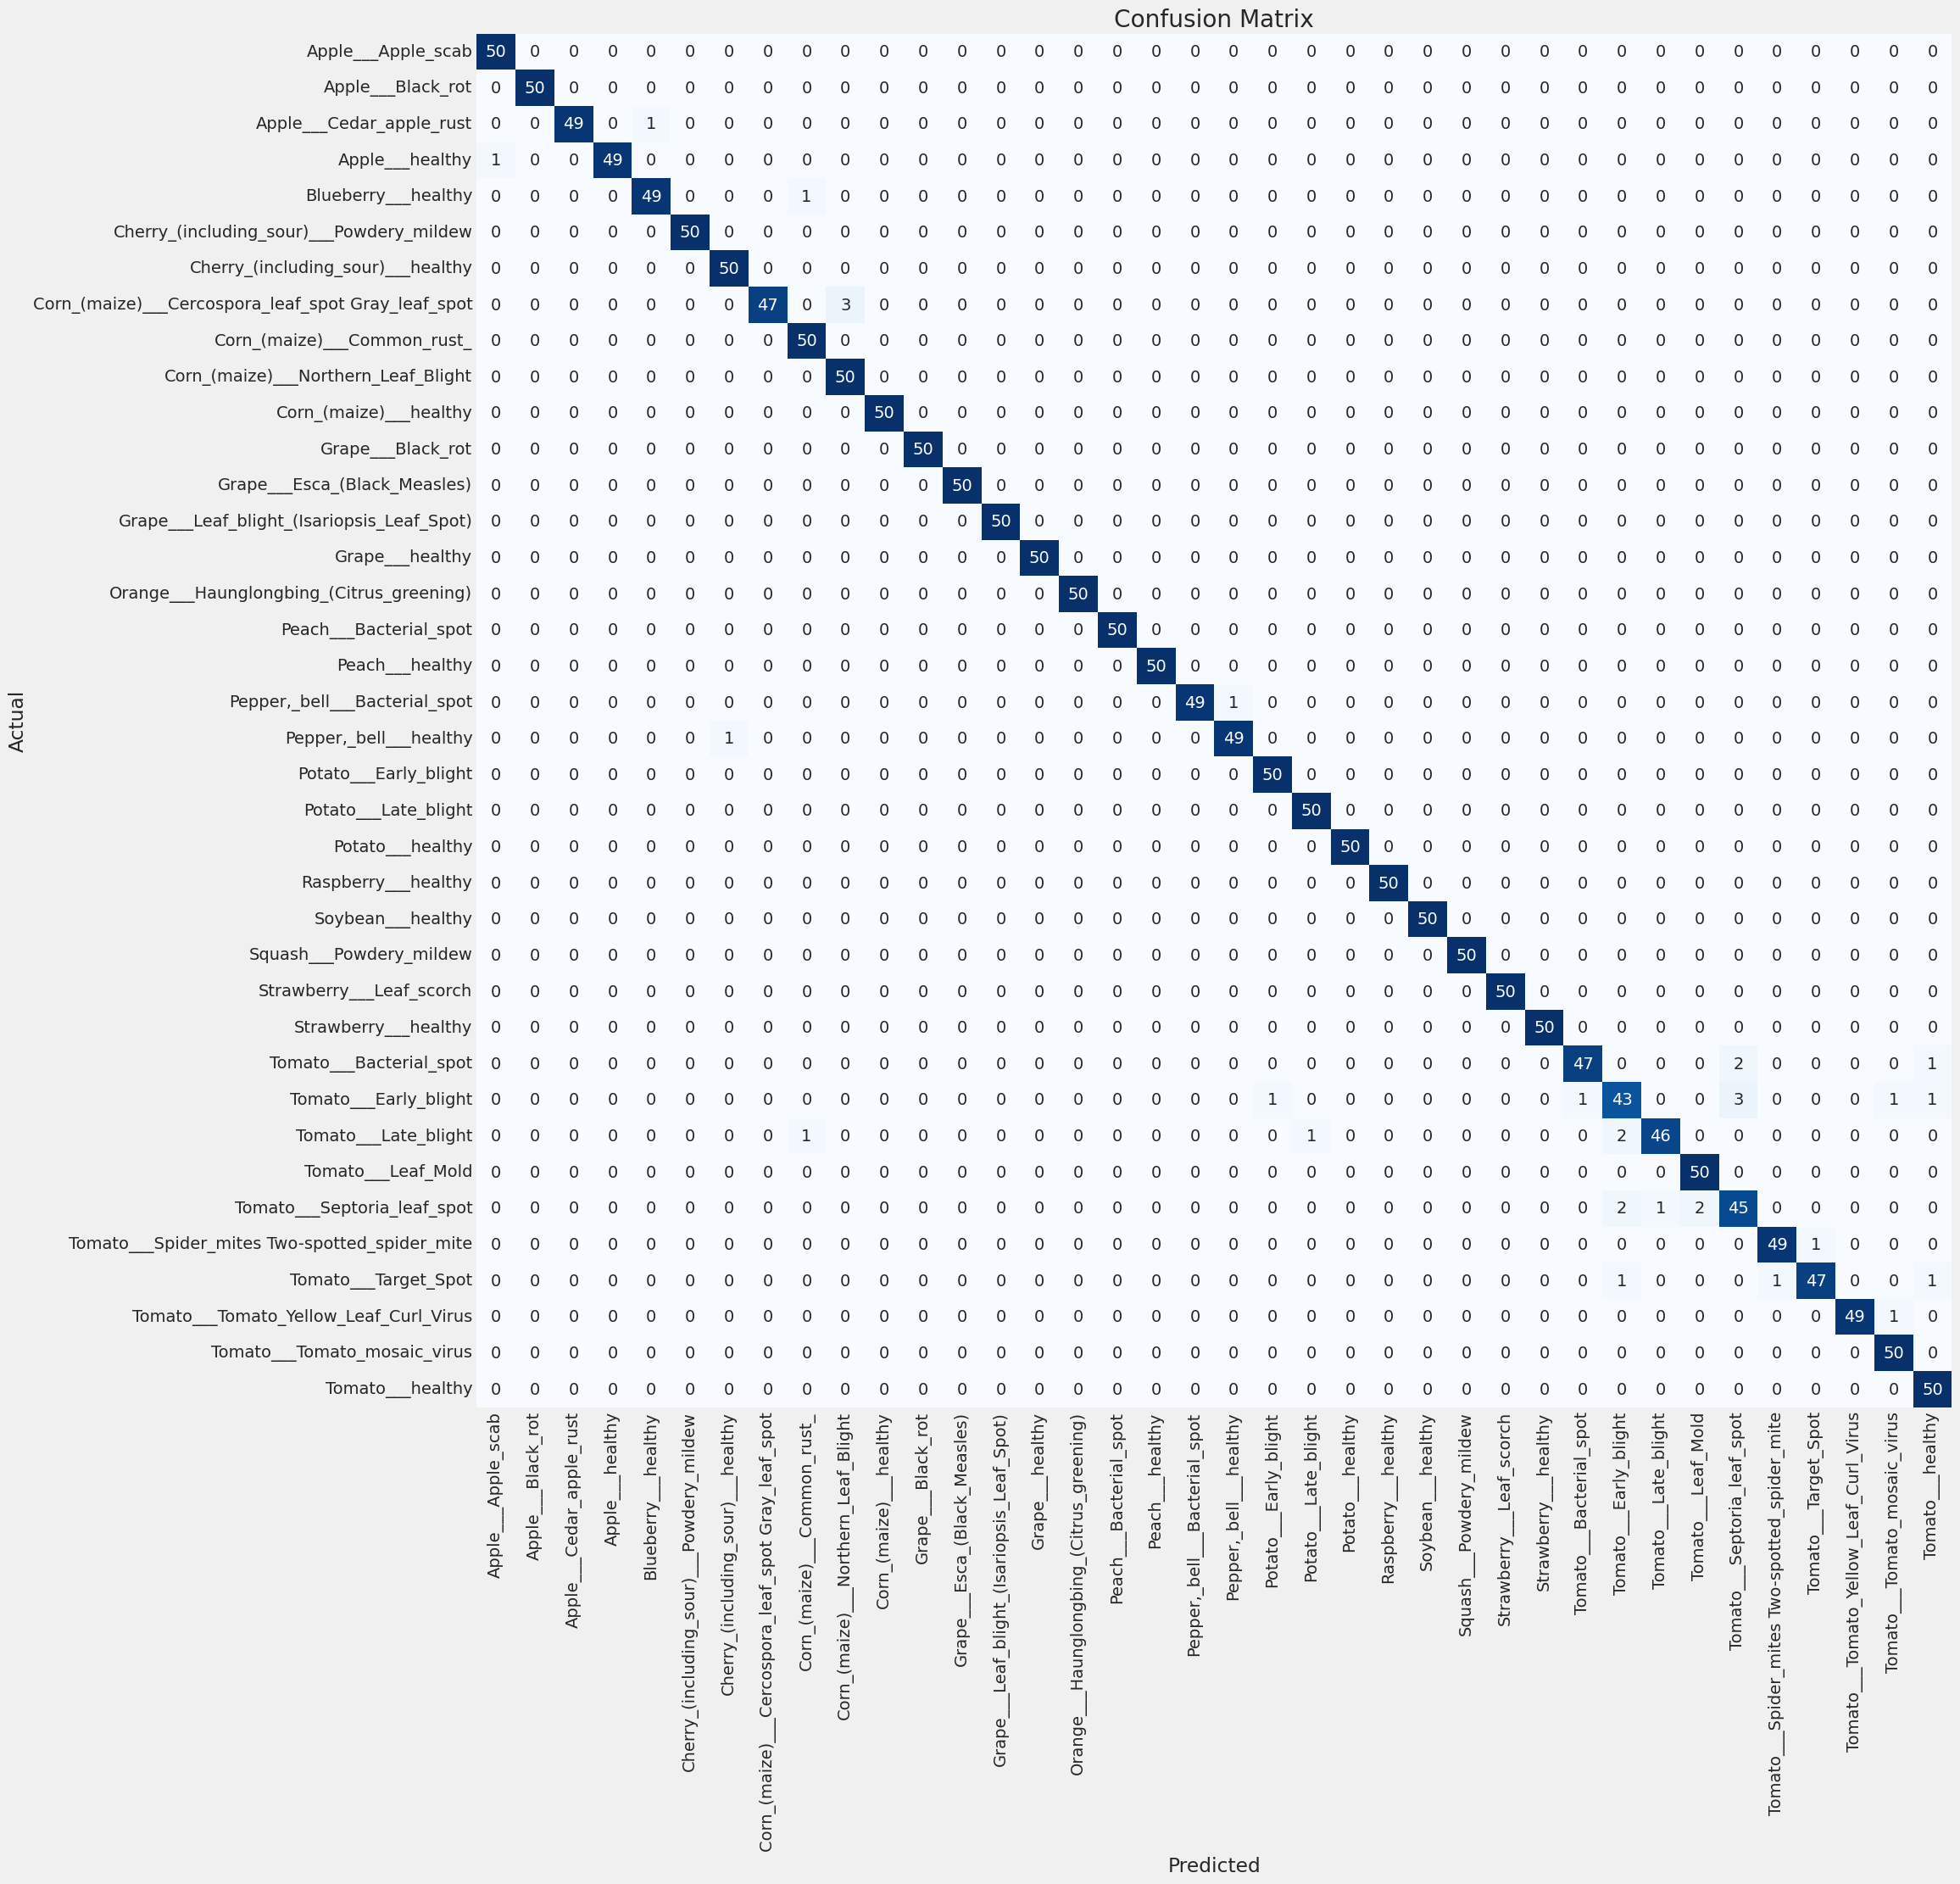

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     0.9804    1.0000    0.9901        50
                                 Apple___Black_rot     1.0000    1.0000    1.0000        50
                          Apple___Cedar_apple_rust     1.0000    0.9800    0.9899        50
                                   Apple___healthy     1.0000    0.9800    0.9899        50
                               Blueberry___healthy     0.9800    0.9800    0.9800        50
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000        50
                 Cherry_(including_sour)___healthy     0.9804    1.0000    0.9901        50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     1.0000    0.9400    0.9691        50
                       Corn_(maize)___Common_rust_     0.9615    1.0000    0.9804        50
               Corn_(maize)___No

In [18]:
img_size = (224, 224)
num_of_classes = 38
lr = 0.0001
model_nums = [1, 2, 3, 4, 5, 6]

results = []

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():

    for model_num in model_nums:
        model = make_model(img_size, num_of_classes, lr, model_num)

        # Define callbacks
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

        model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001)

        callbacks=[early_stopping,model_checkpoint,model_ReduceLROnPlateau]

        epochs = 20
        initial_epoch = 0

        history = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=valid_gen, validation_steps=None, shuffle=True, initial_epoch=initial_epoch)

        tr_plot(history)

        predictor(model, test_gen)

        # Collect results
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]

        results.append({
            'Model': model_num,
            'Train Loss': train_loss,
            'Validation Loss': val_loss,
            'Train Accuracy': train_acc,
            'Validation Accuracy': val_acc
        })

# Print results
for result in results:
    print(result)

In [19]:
import tensorflow as tf
import os
import tempfile

def get_model_info(modnum):
    """
    Gets the name, size, and number of parameters for a pre-trained model.

    Parameters:
    modnum (int): Model number to select the base model.

    Returns:
    tuple: (model_name, model_size, num_params)
    """
    img_shape = (224, 224, 3)  # Example input shape

    if modnum == 1:
        base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        model_name = 'MobileNetV2'
    elif modnum == 2:
        base_model = tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        model_name = 'MobileNetV3Large'
    elif modnum == 3:
        base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        model_name = 'EfficientNetV2B0'
    elif modnum == 4:
        base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        model_name = 'VGG16'
    elif modnum == 5:
        base_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        model_name = 'InceptionResNetV2'
    elif modnum == 6:
        base_model = tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        model_name = 'DenseNet121'
    else:
        raise ValueError("Invalid modnum value. Please choose a value between 1 and 6.")

    # Get model size
    with tempfile.TemporaryDirectory() as tmpdir:
        # Specify filename with .keras extension
        filepath = os.path.join(tmpdir, 'model.keras')
        base_model.save(filepath)
        model_size = sum(os.path.getsize(os.path.join(tmpdir, f)) for f in os.listdir(tmpdir))
    model_size_mb = model_size / (1024 * 1024)  # Convert to MB

    # Get number of parameters
    num_params = base_model.count_params()

    return model_name, model_size_mb, num_params

model_nums = [1, 2, 3, 4, 5, 6]

for model_num in model_nums:
    model_name, model_size, num_params = get_model_info(model_num)
    print(f"Model: {model_name}, Size: {model_size:.2f} MB, Parameters: {num_params}")

Model: MobileNetV2, Size: 9.10 MB, Parameters: 2257984
Model: MobileNetV3Large, Size: 12.15 MB, Parameters: 2996352
Model: EfficientNetV2B0, Size: 23.37 MB, Parameters: 5919312
Model: VGG16, Size: 56.19 MB, Parameters: 14714688
Model: InceptionResNetV2, Size: 209.52 MB, Parameters: 54336736
Model: DenseNet121, Size: 28.11 MB, Parameters: 7037504
